# salvo_compare_line_measurements

Simple notebook for loading in and plotting repeat measurements on the 200 m lines

In [1]:
import os
import re
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import matplotlib.dates as mdates
import pandas as pd
import datetime
import seaborn as sns
import xarray as xr

In [2]:
#salvo_data_root_path = "/mnt/g/My Drive/collaborations/SALVO/field_season_2024/data/temporary_data_analysis/SALVO-2024"
salvo_data_root_path = os.path.join("C:/", "Users", "dclemenssewall", "Desktop", "DavidCS", "NOAA", "projects", 
                                    "SALVO", "data", "salvo-2024-backup", "SALVO-2024-20240619-1305")

In [364]:
def load_salvo_data_str(root_path, sites=None, dates=None, insts=None):
    """
    Loads requested salvo data into an xarray Dataset

    Parameters:
    -----------
    root_path : str
        Filesystem path to the root of the SALVO data directory
    sites : list, optional
        List of site names to load, if None, load all sites. The default is None.
    dates : list, optional
        List of datestrings ('YYYYMMDD') to load, if None, load all dates. The default is None.
    insts : list, optional
        List of instrument names to load, if None, load all instruments. The default is None.

    Returns:
    --------
    Dataset
        xarray dataset containing requested data
    """
    
    # Parse inputs
    if sites is None:
        sites = ['arm', 'beo', 'ice']
    if insts is None:
        raise NotImplementedError

    # Create list containing data arrays for each file
    df_list = []
    dirs = os.listdir(root_path)
    for dir in dirs:
        # Exclude nonselected dates
        if dates is None:
            if not re.search('^20[1,2][0-9]0[4-6][0-3][0-9]', dir):
                continue
        else:
            if not dir[:8] in dates:
                continue
        # Exclude nonselected sites
        site = dir[-3:]
        if not site in sites:
            continue

        # Parse selected sites
        dirs_site = os.listdir(os.path.join(root_path, dir))
        for inst in dirs_site:
            if (inst in insts) and not (inst=='magnaprobe'): # hack for magnaprobe data...
                files_inst = os.listdir(os.path.join(root_path, dir, inst))
                for file in files_inst:
                    if file[-7:]=='.a1.csv' and file[:5]=='salvo':
                        #print(os.path.join(root_path, dir, inst, file))
                        df_list.append(load_salvo_file(os.path.join(root_path, dir, inst, file), inst, site=site))

    # hack for preliminary magnaprobe data...
    if 'magnaprobe' in insts:
        magna_path = os.path.join(root_path, '..', '..', 'magnaprobe200mpreliminary')
        files = os.listdir(magna_path)
        for file in files:
            split_file = re.split(r'_|-|\.', file)
            site = split_file[1]
            if (site in sites) and ((dates is None) or (split_file[5] in dates)):
                df_list.append(load_salvo_file(os.path.join(magna_path, file), 'magnaprobe', site=site))
                        
    return pd.concat(df_list)
        

def load_salvo_file(file_path, inst, site=None):
    """
    Loads requested file into dataframe

    Parameters:
    -----------
    file_path : str
        path to file location
    inst : str
        string specifying type of instrument
    site : str, optional
        string specifying site. The default is None.

    Returns:
    --------
    Dataframe
        pandas dataframe with requested file
    """

    if inst=='kz-mobile':
        df = pd.read_csv(file_path, usecols=['date_akdt', 'timestamp_akdt', 'incident_solar_W_m2', 
                                             'reflected_solar_W_m2', 'site', 'location',
                                             'position', 'repetition', 'albedo'],
                         dtype={'position': 'float64', 'timestamp_akdt':'str'})
        # Convert date and time to timestamp
        # Check whether : is present in timestamp_akdt
        if not df['timestamp_akdt'].str.contains(':[0-9][0-9]').all():
            if df['timestamp_akdt'].str.contains(':[0-9][0-9]').any():
                raise RuntimeError("misformatted timestamp column in: " + file_path)
            else:
                df['timestamp_akdt'] = df['timestamp_akdt'].apply(lambda x: x[:-2]+':'+x[-2:])
        print(file_path)
        df['timestamp_akdt'] = pd.to_datetime(df['date_akdt']+'T'+df['timestamp_akdt']+'-0800', utc=False)
        df.drop(columns=['date_akdt'], inplace=True)
        df['wavelength'] = np.NaN
        df.set_index(['timestamp_akdt', 'site', 'location', 'position', 'repetition', 'wavelength'], inplace=True)
        df['albedo'] = df['reflected_solar_W_m2'] / df['incident_solar_W_m2']
        df = df.melt(ignore_index=False).set_index('variable', append=True)
    if inst=='magnaprobe':
        df = pd.read_csv(file_path, parse_dates=False, usecols=['Timestamp', 'LineLocation', 'SnowDepth'])
        df['site'] = site
        df['location'] = 'line'
        df['repetition'] = 1
        df['wavelength'] = np.NaN
        df.rename(columns={'Timestamp': 'timestamp_akdt', 'LineLocation':'position', 'SnowDepth':'snow_depth_m'},
                  inplace=True)
        df['timestamp_akdt'] = pd.to_datetime(df['timestamp_akdt']+'-0800', utc=False)
        df['water_depth_m'] = -1*df['snow_depth_m'].clip(upper=0)
        df['snow_depth_m'] = df['snow_depth_m'].clip(lower=0)
        df.set_index(['timestamp_akdt', 'site', 'location', 'position', 'repetition', 'wavelength'], inplace=True)
        df = df.melt(ignore_index=False).set_index('variable', append=True)
    return df

def load_gml_albedo(dir_path):
    files = os.listdir(dir_path)
    df_list = []
    for file in files:
        df_list.append(pd.read_csv(os.path.join(dir_path, file), skiprows=2, sep=r'\s+',
                      names=['year', 'jd', 'month', 'day', 'hour', 'minute', 'dt', 'zen', 
                             'incident_solar_W_m2', 'incident_solar_W_m2_qc', 
                             'reflected_solar_W_m2', 'reflected_solar_W_m2_qc',
                             'direct_solar_W_m2', 'direct_solar_W_m2_qc',
                             'diffuse_solar_W_m2', 'diffuse_solar_W_m2_qc'],
                      usecols=np.arange(16)))
    df_gml = pd.concat(df_list, ignore_index=True)
    df_gml['timestamp_utc'] = pd.to_datetime(df_gml[['year', 'month', 'day', 'hour', 'minute']], utc=True)
    df_gml.drop(columns=['year', 'month', 'day', 'hour', 'minute', 'jd', 'dt'], inplace=True)
    df_gml.set_index('timestamp_utc', inplace=True)
    return df_gml

def preprocess_rap(ds):
    utq_site = 6
    sel_vars = ['stemp0', 'lflux0', 'sflux0', 'gflux0', 'dswsfc0', 'uswsfc0',
                'dlwsfc0', 'ulwsfc0', 'prate0', 'paccum0', 'csnow0', 'dswdbeam0', 
                'dswdiffuse0', 'tsfc0', 'usfc0', 'vsfc0']
    
    ds_rap_sel = ds.sel(sites=utq_site)[sel_vars]
    
    init_time = ds.model_initialization.sel(forecast_hour=0).values
    time = init_time + ds.forecast_hour.values.astype('timedelta64[h]')
    
    ds_rap_sel['forecast_hour'] = ('forecast_hour', time)
    ds_rap_sel = ds_rap_sel.rename({'forecast_hour':'time'})
    ds_rap_sel = ds_rap_sel.assign_coords({'model_initialization': init_time})
    ds_rap_sel = ds_rap_sel.expand_dims(dim="model_initialization")

    return ds_rap_sel

In [357]:
# Explore loading RAP data
dir_path = os.path.join("C:/", "Users", "dclemenssewall", "Desktop", "DavidCS", "NOAA", "projects", 
                        "SALVO", "data", "rap")
#filename = "profiler_sitesF.ncep_rap.2024150.2100.nc"
#ds_rap = xr.open_dataset(os.path.join(dir_path, filename))
#utq_lon = -156.8
#utq_lat = 71.29
#print(np.abs(ds_rap.mlon-utq_lon).argmin())
#print(np.abs(ds_rap.mlat-utq_lat).argmin())

filename = "profiler_sitesF.ncep_rap.202413*.2100.nc"
ds_rap130 = xr.open_mfdataset(os.path.join(dir_path, filename), preprocess=preprocess_rap,
                          combine="nested")
filename = "profiler_sitesF.ncep_rap.202414*.2100.nc"
ds_rap140 = xr.open_mfdataset(os.path.join(dir_path, filename), preprocess=preprocess_rap,
                          combine="nested")
filename = "profiler_sitesF.ncep_rap.202415*.2100.nc"
ds_rap150 = xr.open_mfdataset(os.path.join(dir_path, filename), preprocess=preprocess_rap,
                          combine="nested")
filename = "profiler_sitesF.ncep_rap.202416*.2100.nc"
ds_rap160 = xr.open_mfdataset(os.path.join(dir_path, filename), preprocess=preprocess_rap,
                          combine="nested")

In [358]:
ds_rap = xr.combine_nested([ds_rap130, ds_rap140, ds_rap150, ds_rap160], 'model_initialization')

C:\Users\dclemenssewall\.conda\envs\basic_plotting\Lib\site-packages\dask\array\core.py:4888: PerformanceWarning: Increasing number of chunks by factor of 10
  result = blockwise(
C:\Users\dclemenssewall\.conda\envs\basic_plotting\Lib\site-packages\dask\array\core.py:4888: PerformanceWarning: Increasing number of chunks by factor of 10
  result = blockwise(
C:\Users\dclemenssewall\.conda\envs\basic_plotting\Lib\site-packages\dask\array\core.py:4888: PerformanceWarning: Increasing number of chunks by factor of 10
  result = blockwise(
C:\Users\dclemenssewall\.conda\envs\basic_plotting\Lib\site-packages\dask\array\core.py:4888: PerformanceWarning: Increasing number of chunks by factor of 10
  result = blockwise(
C:\Users\dclemenssewall\.conda\envs\basic_plotting\Lib\site-packages\dask\array\core.py:4888: PerformanceWarning: Increasing number of chunks by factor of 10
  result = blockwise(
C:\Users\dclemenssewall\.conda\envs\basic_plotting\Lib\site-packages\dask\array\core.py:4888: Perfor

In [359]:
ds_rap['albedo'] = ds_rap['uswsfc0']/ds_rap['dswsfc0']

In [4]:
dir_path = os.path.join("C:/", "Users", "dclemenssewall", "Desktop", "DavidCS", "NOAA", "projects", 
                        "SALVO", "data", "gml_albedo_rack")
df_gml = load_gml_albedo(dir_path)

df_gml['incident_bestestimate_W_m2'] = df_gml['direct_solar_W_m2']*np.cos(df_gml['zen']*np.pi/180) + df_gml['diffuse_solar_W_m2']
df_gml['incident_bestestimate_W_m2_qc'] = df_gml['direct_solar_W_m2_qc'] + df_gml['diffuse_solar_W_m2_qc']

In [5]:
df = load_salvo_data_str(salvo_data_root_path, dates=None,insts=['kz-mobile','magnaprobe'], sites=['arm', 'beo', 'ice'])

C:/Users\dclemenssewall\Desktop\DavidCS\NOAA\projects\SALVO\data\salvo-2024-backup\SALVO-2024-20240619-1305\20240417-ice\kz-mobile\salvo_ice_all_kz-mobile_20240417.a1.csv
C:/Users\dclemenssewall\Desktop\DavidCS\NOAA\projects\SALVO\data\salvo-2024-backup\SALVO-2024-20240619-1305\20240419-arm\kz-mobile\salvo_arm_all_kz-mobile_20240419.a1.csv
C:/Users\dclemenssewall\Desktop\DavidCS\NOAA\projects\SALVO\data\salvo-2024-backup\SALVO-2024-20240619-1305\20240420-beo\kz-mobile\salvo_beo_all_kz-mobile_20240420.a1.csv
C:/Users\dclemenssewall\Desktop\DavidCS\NOAA\projects\SALVO\data\salvo-2024-backup\SALVO-2024-20240619-1305\20240421-ice\kz-mobile\salvo_ice_all_kz-mobile_20240421.a1.csv


C:\Users\dclemenssewall\AppData\Local\Temp\ipykernel_37952\951950857.py:99: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df['timestamp_akdt'] = pd.to_datetime(df['date_akdt']+'T'+df['timestamp_akdt']+'-0800', utc=False)
C:\Users\dclemenssewall\AppData\Local\Temp\ipykernel_37952\951950857.py:99: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df['timestamp_akdt'] = pd.to_datetime(df['date_akdt']+'T'+df['timestamp_akdt']+'-0800', utc=False)


C:/Users\dclemenssewall\Desktop\DavidCS\NOAA\projects\SALVO\data\salvo-2024-backup\SALVO-2024-20240619-1305\20240523-beo\kz-mobile\salvo_beo_line_kz-mobile_20240523.a1.csv
C:/Users\dclemenssewall\Desktop\DavidCS\NOAA\projects\SALVO\data\salvo-2024-backup\SALVO-2024-20240619-1305\20240524-arm\kz-mobile\salvo_arm_line_kz-mobile_20240524.a1.csv
C:/Users\dclemenssewall\Desktop\DavidCS\NOAA\projects\SALVO\data\salvo-2024-backup\SALVO-2024-20240619-1305\20240525-arm\kz-mobile\salvo_arm_line_kz-mobile_20240525.a1.csv
C:/Users\dclemenssewall\Desktop\DavidCS\NOAA\projects\SALVO\data\salvo-2024-backup\SALVO-2024-20240619-1305\20240526-ice\kz-mobile\salvo_ice_all_kz-mobile_20240526.00.a1.csv


C:\Users\dclemenssewall\AppData\Local\Temp\ipykernel_37952\951950857.py:99: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df['timestamp_akdt'] = pd.to_datetime(df['date_akdt']+'T'+df['timestamp_akdt']+'-0800', utc=False)
C:\Users\dclemenssewall\AppData\Local\Temp\ipykernel_37952\951950857.py:99: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df['timestamp_akdt'] = pd.to_datetime(df['date_akdt']+'T'+df['timestamp_akdt']+'-0800', utc=False)
C:\Users\dclemenssewall\AppData\Local\Temp\ipykernel_37952\951950857.py:99: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df['timestamp_ak

C:/Users\dclemenssewall\Desktop\DavidCS\NOAA\projects\SALVO\data\salvo-2024-backup\SALVO-2024-20240619-1305\20240527-arm\kz-mobile\salvo_arm_all_kz-mobile_20240527.a1.csv
C:/Users\dclemenssewall\Desktop\DavidCS\NOAA\projects\SALVO\data\salvo-2024-backup\SALVO-2024-20240619-1305\20240527-arm\kz-mobile\salvo_arm_library_kz-mobile_20240527.a1.csv
C:/Users\dclemenssewall\Desktop\DavidCS\NOAA\projects\SALVO\data\salvo-2024-backup\SALVO-2024-20240619-1305\20240527-arm\kz-mobile\salvo_arm_line_kz-mobile_20240527.a1.csv
C:/Users\dclemenssewall\Desktop\DavidCS\NOAA\projects\SALVO\data\salvo-2024-backup\SALVO-2024-20240619-1305\20240529-arm\kz-mobile\salvo_arm_all_kz-mobile_20240529.a1.csv


C:\Users\dclemenssewall\AppData\Local\Temp\ipykernel_37952\951950857.py:99: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df['timestamp_akdt'] = pd.to_datetime(df['date_akdt']+'T'+df['timestamp_akdt']+'-0800', utc=False)


C:/Users\dclemenssewall\Desktop\DavidCS\NOAA\projects\SALVO\data\salvo-2024-backup\SALVO-2024-20240619-1305\20240529-beo\kz-mobile\salvo_beo_line_kz-mobile_20240529.a1.csv
C:/Users\dclemenssewall\Desktop\DavidCS\NOAA\projects\SALVO\data\salvo-2024-backup\SALVO-2024-20240619-1305\20240530-ice\kz-mobile\salvo_ice_line_kz-mobile_20240530.a1.csv
C:/Users\dclemenssewall\Desktop\DavidCS\NOAA\projects\SALVO\data\salvo-2024-backup\SALVO-2024-20240619-1305\20240602-beo\kz-mobile\salvo_beo_all_kz-mobile_20240602.a1.csv
C:/Users\dclemenssewall\Desktop\DavidCS\NOAA\projects\SALVO\data\salvo-2024-backup\SALVO-2024-20240619-1305\20240603-arm\kz-mobile\salvo_arm_line_kz-mobile_20240603.a1.csv
C:/Users\dclemenssewall\Desktop\DavidCS\NOAA\projects\SALVO\data\salvo-2024-backup\SALVO-2024-20240619-1305\20240604-ice\kz-mobile\salvo_ice_line_kz-mobile_20240604.a1.csv


C:\Users\dclemenssewall\AppData\Local\Temp\ipykernel_37952\951950857.py:99: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df['timestamp_akdt'] = pd.to_datetime(df['date_akdt']+'T'+df['timestamp_akdt']+'-0800', utc=False)


C:/Users\dclemenssewall\Desktop\DavidCS\NOAA\projects\SALVO\data\salvo-2024-backup\SALVO-2024-20240619-1305\20240605-arm\kz-mobile\salvo_arm_all_kz-mobile_20240605.a1.csv
C:/Users\dclemenssewall\Desktop\DavidCS\NOAA\projects\SALVO\data\salvo-2024-backup\SALVO-2024-20240619-1305\20240605-beo\kz-mobile\salvo_beo_all_kz-mobile_20240605.a1.csv
C:/Users\dclemenssewall\Desktop\DavidCS\NOAA\projects\SALVO\data\salvo-2024-backup\SALVO-2024-20240619-1305\20240606-arm\kz-mobile\salvo_arm_all_kz-mobile_20240606.a1.csv
C:/Users\dclemenssewall\Desktop\DavidCS\NOAA\projects\SALVO\data\salvo-2024-backup\SALVO-2024-20240619-1305\20240607-ice\kz-mobile\salvo_ice_all_kz-mobile_20240607.a1.csv


C:\Users\dclemenssewall\AppData\Local\Temp\ipykernel_37952\951950857.py:99: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df['timestamp_akdt'] = pd.to_datetime(df['date_akdt']+'T'+df['timestamp_akdt']+'-0800', utc=False)
C:\Users\dclemenssewall\AppData\Local\Temp\ipykernel_37952\951950857.py:99: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df['timestamp_akdt'] = pd.to_datetime(df['date_akdt']+'T'+df['timestamp_akdt']+'-0800', utc=False)


C:/Users\dclemenssewall\Desktop\DavidCS\NOAA\projects\SALVO\data\salvo-2024-backup\SALVO-2024-20240619-1305\20240608-beo\kz-mobile\salvo_beo_all_kz-mobile_20240608.a1.csv
C:/Users\dclemenssewall\Desktop\DavidCS\NOAA\projects\SALVO\data\salvo-2024-backup\SALVO-2024-20240619-1305\20240610-arm\kz-mobile\salvo_arm_all_kz-mobile_20240610.a1.csv
C:/Users\dclemenssewall\Desktop\DavidCS\NOAA\projects\SALVO\data\salvo-2024-backup\SALVO-2024-20240619-1305\20240610-ice\kz-mobile\salvo_ice_all_kz-mobile_20240610.a1.csv
C:/Users\dclemenssewall\Desktop\DavidCS\NOAA\projects\SALVO\data\salvo-2024-backup\SALVO-2024-20240619-1305\20240611-beo\kz-mobile\salvo_beo_all_kz-mobile_20240611.a1.csv


C:\Users\dclemenssewall\AppData\Local\Temp\ipykernel_37952\951950857.py:99: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df['timestamp_akdt'] = pd.to_datetime(df['date_akdt']+'T'+df['timestamp_akdt']+'-0800', utc=False)


C:/Users\dclemenssewall\Desktop\DavidCS\NOAA\projects\SALVO\data\salvo-2024-backup\SALVO-2024-20240619-1305\20240612-arm\kz-mobile\salvo_arm_all_kz-mobile_20240612.a1.csv
C:/Users\dclemenssewall\Desktop\DavidCS\NOAA\projects\SALVO\data\salvo-2024-backup\SALVO-2024-20240619-1305\20240613-ice\kz-mobile\salvo_ice_all_kz-mobile_20240613.a1.csv
C:/Users\dclemenssewall\Desktop\DavidCS\NOAA\projects\SALVO\data\salvo-2024-backup\SALVO-2024-20240619-1305\20240614-beo\kz-mobile\salvo_beo_all_kz-mobile_20240614.a1.csv
C:/Users\dclemenssewall\Desktop\DavidCS\NOAA\projects\SALVO\data\salvo-2024-backup\SALVO-2024-20240619-1305\20240615-arm\kz-mobile\salvo_arm_all_kz-mobile_20240615.a1.csv
C:/Users\dclemenssewall\Desktop\DavidCS\NOAA\projects\SALVO\data\salvo-2024-backup\SALVO-2024-20240619-1305\20240615-ice\kz-mobile\salvo_ice_all_kz-mobile_20240615.a1.csv
C:/Users\dclemenssewall\Desktop\DavidCS\NOAA\projects\SALVO\data\salvo-2024-backup\SALVO-2024-20240619-1305\20240617-arm\kz-mobile\salvo_arm_all_

In [6]:
# Load CAFS output
cafs_path = os.path.join("C:/", "Users", "dclemenssewall", "Desktop", "DavidCS", "NOAA", "projects", 
                        "SALVO", "data", "CAFS", "Utqiagvik_h0_lnd.nc")
ds_cafs = xr.load_dataset(cafs_path)
df_cafs = ds_cafs[['FSDS', 'FSNO_EFF', 'FSR', 'SNOWDP', 'SNOW_DEPTH', 'TSA', 'FLDS', 'TG', 'FSH', 'EFLX_LH_TOT']].squeeze().to_dataframe()
df_cafs['timestamp_utc'] = df_cafs.index.tz_localize('UTC')
df_cafs.set_index('timestamp_utc', inplace=True)
df_cafs['albedo'] = df_cafs['FSR']/df_cafs['FSDS']

In [7]:
ds_cafs

<xarray.Dataset>
Dimensions:                (levgrnd: 15, levlak: 10, levdcmp: 1, time: 53,
                            hist_interval: 2, lon: 1, lat: 1)
Coordinates:
  * levgrnd                (levgrnd) float32 0.007101 0.02792 ... 21.33 35.18
  * levlak                 (levlak) float32 0.05 0.6 2.1 ... 25.6 34.33 44.78
  * levdcmp                (levdcmp) float32 1.0
  * time                   (time) datetime64[ns] 2024-06-01 ... 2024-06-14
  * lon                    (lon) float32 196.8
  * lat                    (lat) float32 65.88
Dimensions without coordinates: hist_interval
Data variables: (12/206)
    mcdate                 (time) int32 20240601 20240601 ... 20240613 20240614
    mcsec                  (time) int32 0 21600 43200 64800 ... 43200 64800 0
    mdcur                  (time) int32 0 0 0 0 1 1 1 1 ... 11 11 12 12 12 12 13
    mscur                  (time) int32 0 21600 43200 64800 ... 43200 64800 0
    nstep                  (time) int32 0 24 48 72 96 ... 1176 1200 1224 1248
    time_bounds            (time, hist_interval) datetime64[ns] 2024-05-31T23...
    ...                     ...
    WA                     (time, lat, lon) float32 3.998e+03 ... 3.998e+03
    WASTEHEAT              (time, lat, lon) float32 0.0 0.0 0.0 ... 0.0 0.0 0.0
    WIND                   (time, lat, lon) float32 1.632 2.143 ... 5.704 5.954
    ZBOT                   (time, lat, lon) float32 12.75 12.74 ... 12.76 12.79
    ZWT                    (time, lat, lon) float32 8.808 8.808 ... 8.808 8.808
    ZWT_PERCH              (time, lat, lon) float32 0.007101 ... 0.01732
Attributes: (12/15)
    title:                                CLM History file information
    comment:                              NOTE: None of the variables are wei...
    Conventions:                          CF-1.0
    history:                              Mon Oct  7 09:24:29 2024: ncrcat -d...
    source:                               Community Land Model CLM4.0
    hostname:                             theia
    ...                                   ...
    case_title:                           UNSET
    case_id:                              CAFS1d
    Surface_dataset:                      surfdata_wr10b_simyr2000_c170705.nc
    Initial_conditions_dataset:           REB2.clm2.r.2024-06-01-00000.nc
    PFT_physiological_constants_dataset:  pft-physiology.c130503.nc
    NCO:                                  netCDF Operators version 4.8.1 (Hom...

In [8]:
# Load NSA qcrad data
nsa_path = os.path.join("C:/", "Users", "dclemenssewall", "Desktop", "DavidCS", "NOAA", "projects", 
                        "SALVO", "data", "nsaqcrad", "*.cdf")
ds_nsa = xr.open_mfdataset(nsa_path)

In [9]:
varnames = ['BestEstimate_down_short_hemisp', 'up_short_hemisp',
            'down_long_hemisp', 'up_long_hemisp',
            'Temp_Air', 'wind_speed']
da_list = []
for varname in varnames:
    da_list.append(ds_nsa[varname].where(ds_nsa['qc_'+varname]==0))
df_nsa = xr.merge(da_list).to_dataframe()
df_nsa['timestamp_utc'] = df_nsa.index.tz_localize('UTC')
df_nsa.set_index('timestamp_utc', inplace=True)
df_nsa['albedo'] = df_nsa['up_short_hemisp']/df_nsa['BestEstimate_down_short_hemisp']

In [10]:
# Load NSA ecor data
ecr_path = os.path.join("C:/", "Users", "dclemenssewall", "Desktop", "DavidCS", "NOAA", "projects", 
                        "SALVO", "data", "nsa30ecor", "*.cdf")
ds_ecr = xr.open_mfdataset(ecr_path)

In [11]:
varnames = ['h', 'lv_e',
            'mean_t', 'wind_spd']
da_list = []
for varname in varnames:
    da_list.append(ds_ecr[varname].where(ds_ecr['qc_'+varname]==0))
df_ecr = xr.merge(da_list).to_dataframe()
df_ecr['timestamp_utc'] = df_ecr.index.tz_localize('UTC')
df_ecr.set_index('timestamp_utc', inplace=True)

In [12]:
s_times = df.xs(('line', 'albedo'), level=('location', 'variable')).index.get_level_values('timestamp_akdt').to_series()
s_times.index = s_times.index.normalize()
s_times.index.name = 'date_akdt'
df_times = s_times.reset_index()
df_times['time_of_day'] = df_times['timestamp_akdt'] - df_times['date_akdt']
print('Average time of day that line albedo measurements were made:')
df_times['time_of_day'].mean()
#df_temp.index = df_temp.index.set_levels(df_temp.index.levels[0].normalize(), level=0, verify_integrity=False)

Average time of day that line albedo measurements were made:


Timedelta('0 days 14:24:14.520547945')

In [13]:
start = '2024-05-20'
end = '2024-06-19'
df_temp = df_gml.copy()
df_temp.index = df_temp.index.tz_convert('-0800').rename('timestamp_akdt')
df_temp = df_temp.groupby(df_temp.index.normalize())['zen'].agg('idxmin')[start:end].reset_index()
df_temp['time_of_day'] = df_temp['zen'] - df_temp['timestamp_akdt']
print('Average time of day of minimum solar zenith angle ' + start + ' to ' + end)
df_temp['time_of_day'].mean()

Average time of day of minimum solar zenith angle 2024-05-20 to 2024-06-19


Timedelta('0 days 14:21:23.225806451')

In [14]:
def line_date_agg(df, variable, time_of_day='14:24:00'):
    df_temp = df.xs(('line', variable), level=('location', 'variable'))
    df_temp = df_temp.reset_index()
    df_temp['date_akdt'] = pd.to_datetime(df_temp['timestamp_akdt'].dt.date) + pd.Timedelta(time_of_day)
    df_temp = pd.merge(df_temp.groupby(['site', 'date_akdt', 'position'])['value'].mean(),
                       df_temp[['site', 'date_akdt', 'timestamp_akdt']].groupby(
                           ['site', 'date_akdt']).mean(),
                       left_index=True, right_index=True)
    df_temp = df_temp.rename(columns={'value':variable, 'timestamp_akdt':'meantime_akdt'})
    return df_temp

C:\Users\dclemenssewall\AppData\Local\Temp\ipykernel_37952\3494737225.py:50: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp['albedo'] = df_temp['reflected_solar_W_m2'] / df_temp['incident_bestestimate_W_m2']


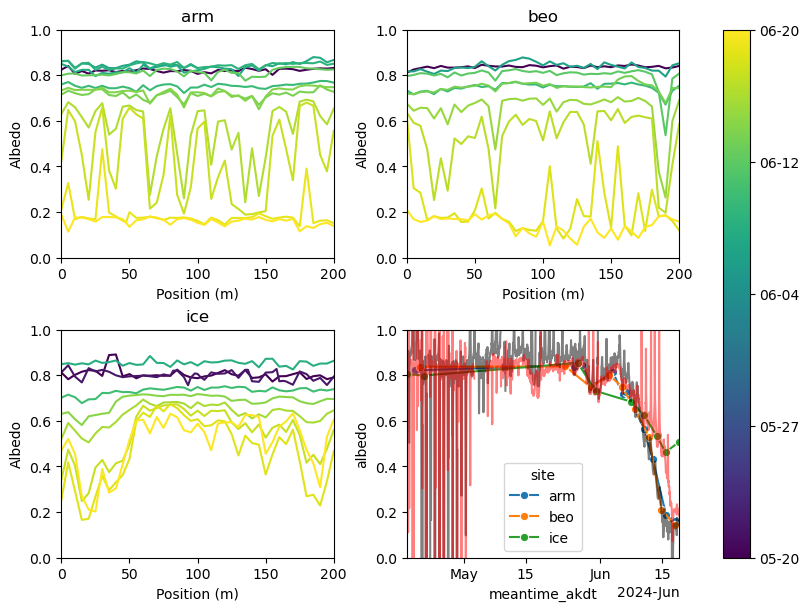

In [15]:
# Plot all albedo lines albedo
color_start_date = pd.Timestamp('2024-05-20T00:00:00-0800')
color_end_date = pd.Timestamp('2024-06-20T00:00:00-0800')

df_temp = line_date_agg(df, 'albedo')
df_temp = df_temp.query('position != -999.0')
df_temp['timestamp_cbar'] = (df_temp['meantime_akdt'] - color_start_date)/(color_end_date - color_start_date)

#df_temp = df_temp.xs(site, level='site').reset_index()


f, axs = plt.subplots(2, 2, figsize=(8, 6), layout='constrained')

site = 'arm'
sns.lineplot(data=df_temp.xs(site, level='site').reset_index(), x='position', y='albedo', 
             hue='timestamp_cbar', palette='viridis', ax=axs[0,0])
axs[0,0].get_legend().remove()
axs[0,0].set_title(site)
axs[0,0].set_ylim([0, 1.0])
axs[0,0].set_xlim([0, 200])
axs[0,0].set_xlabel('Position (m)')
axs[0,0].set_ylabel('Albedo')

site = 'beo'
sns.lineplot(data=df_temp.xs(site, level='site').reset_index(), x='position', y='albedo', 
             hue='timestamp_cbar', palette='viridis', ax=axs[0,1])
axs[0,1].get_legend().remove()
axs[0,1].set_title(site)
axs[0,1].set_ylim([0, 1.0])
axs[0,1].set_xlim([0, 200])
axs[0,1].set_xlabel('Position (m)')
axs[0,1].set_ylabel('Albedo')

site = 'ice'
sns.lineplot(data=df_temp.xs(site, level='site').reset_index(), x='position', y='albedo', 
             hue='timestamp_cbar', palette='viridis', ax=axs[1,0])
axs[1,0].get_legend().remove()
axs[1,0].set_title(site)
axs[1,0].set_ylim([0, 1.0])
axs[1,0].set_xlim([0, 200])
axs[1,0].set_xlabel('Position (m)')
axs[1,0].set_ylabel('Albedo')

# Comparison
sns.lineplot(data=df_temp.groupby(['site', 'date_akdt']).mean(), 
             x='meantime_akdt', y='albedo', hue='site', ax=axs[1,1],
            marker='o')
# hourly albedo rack
df_temp = df_gml.query("(incident_bestestimate_W_m2_qc==0) and (reflected_solar_W_m2_qc==0)")
df_temp['albedo'] = df_temp['reflected_solar_W_m2'] / df_temp['incident_bestestimate_W_m2']
df_temp = df_temp['albedo'].resample('1h').mean()
df_temp.index = df_temp.index.tz_convert('-0800').rename('timestamp_akdt')
df_temp = df_temp.reset_index()
axs[1,1].plot('timestamp_akdt', 'albedo', data=df_temp, c='k', alpha=0.5)

# hourly nsa albedo
df_temp = df_nsa['albedo'].resample('1h').mean()
df_temp.index = df_temp.index.tz_convert('-0800').rename('timestamp_akdt')
df_temp = df_temp.reset_index()
axs[1,1].plot('timestamp_akdt', 'albedo', data=df_temp, c='r', alpha=0.5)

axs[1,1].set_xlim([df.index.get_level_values('timestamp_akdt').min(),
            df.index.get_level_values('timestamp_akdt').max()])
axs[1,1].set_ylim(0, 1.0)
locator = mdates.AutoDateLocator(minticks=3, maxticks=7)
formatter = mdates.ConciseDateFormatter(locator)
axs[1,1].xaxis.set_major_locator(locator)
axs[1,1].xaxis.set_major_formatter(formatter)


cmap = mpl.cm.viridis
norm = mpl.colors.Normalize(vmin=0,
                            vmax=1.0)

cbar = f.colorbar(mpl.cm.ScalarMappable(norm=norm, cmap=cmap),
           ax=axs, orientation='vertical')

n_ticks = 5
cbar.set_ticks(np.linspace(0.0, 1.0, num=n_ticks))
cbar.ax.set_yticklabels(pd.date_range(start=color_start_date, end=color_end_date,
              periods=n_ticks).strftime('%m-%d'))

plt.show()

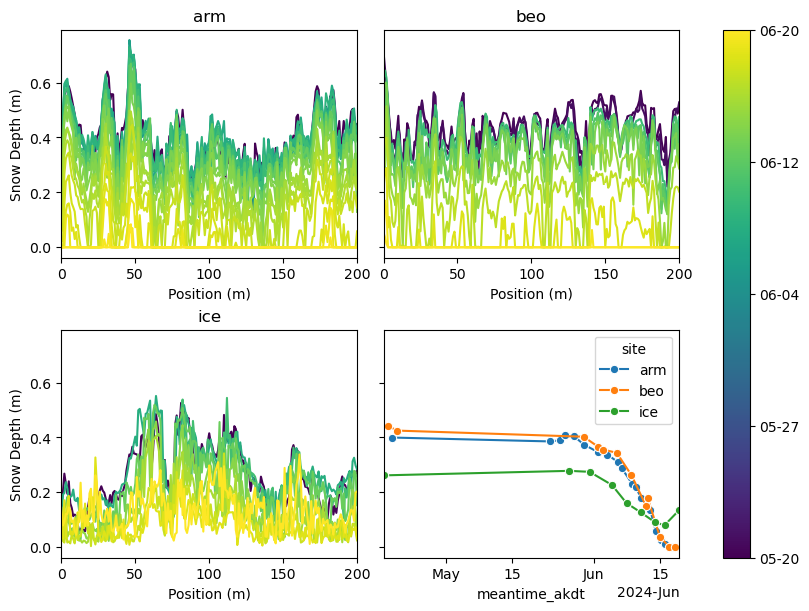

In [16]:
# Plot all albedo lines snow depth
color_start_date = pd.Timestamp('2024-05-20T00:00:00-0800')
color_end_date = pd.Timestamp('2024-06-20T00:00:00-0800')

df_temp = line_date_agg(df, 'snow_depth_m')
df_temp = df_temp.query('position != -999.0')
df_temp['timestamp_cbar'] = (df_temp['meantime_akdt'] - color_start_date)/(color_end_date - color_start_date)

#df_temp = df_temp.xs(site, level='site').reset_index()


f, axs = plt.subplots(2, 2, figsize=(8, 6), sharey=True, layout='constrained')

site = 'arm'
sns.lineplot(data=df_temp.xs(site, level='site').reset_index(), x='position', y='snow_depth_m', 
             hue='timestamp_cbar', palette='viridis', ax=axs[0,0])
axs[0,0].get_legend().remove()
axs[0,0].set_title(site)
axs[0,0].set_xlim([0, 200])
axs[0,0].set_xlabel('Position (m)')
axs[0,0].set_ylabel('Snow Depth (m)')

site = 'beo'
sns.lineplot(data=df_temp.xs(site, level='site').reset_index(), x='position', y='snow_depth_m', 
             hue='timestamp_cbar', palette='viridis', ax=axs[0,1])
axs[0,1].get_legend().remove()
axs[0,1].set_title(site)
axs[0,1].set_xlim([0, 200])
axs[0,1].set_xlabel('Position (m)')
axs[0,1].set_ylabel('Snow Depth (m)')

site = 'ice'
sns.lineplot(data=df_temp.xs(site, level='site').reset_index(), x='position', y='snow_depth_m', 
             hue='timestamp_cbar', palette='viridis', ax=axs[1,0])
axs[1,0].get_legend().remove()
axs[1,0].set_title(site)
axs[1,0].set_xlim([0, 200])
axs[1,0].set_xlabel('Position (m)')
axs[1,0].set_ylabel('Snow Depth (m)')

# Comparison
sns.lineplot(data=df_temp.groupby(['site', 'date_akdt']).mean(), 
             x='meantime_akdt', y='snow_depth_m', hue='site', ax=axs[1,1],
            marker='o')
axs[1,1].set_xlim([df.index.get_level_values('timestamp_akdt').min(),
            df.index.get_level_values('timestamp_akdt').max()])
locator = mdates.AutoDateLocator(minticks=3, maxticks=7)
formatter = mdates.ConciseDateFormatter(locator)
axs[1,1].xaxis.set_major_locator(locator)
axs[1,1].xaxis.set_major_formatter(formatter)


cmap = mpl.cm.viridis
norm = mpl.colors.Normalize(vmin=0,
                            vmax=1.0)

cbar = f.colorbar(mpl.cm.ScalarMappable(norm=norm, cmap=cmap),
           ax=axs, orientation='vertical')

n_ticks = 5
cbar.set_ticks(np.linspace(0.0, 1.0, num=n_ticks))
cbar.ax.set_yticklabels(pd.date_range(start=color_start_date, end=color_end_date,
              periods=n_ticks).strftime('%m-%d'))

plt.show()

In [17]:
# explore albedo vs snow depth
df_temp = pd.merge(line_date_agg(df, 'albedo'),
                   line_date_agg(df, 'snow_depth_m'),
                   left_index=True, right_index=True)

In [18]:
df_temp.groupby(level=['site','date_akdt']).mean()

albedo                     meantime_akdt_x  \
site date_akdt                                                           
arm  2024-04-19 14:24:00  0.821019 2024-04-19 13:27:57.073170688-08:00   
     2024-05-24 14:24:00  0.843656 2024-05-24 15:58:05.714285824-08:00   
     2024-05-25 14:24:00  0.834529 2024-05-25 14:57:23.414634240-08:00   
     2024-05-27 14:24:00  0.844855 2024-05-27 12:32:21.951219456-08:00   
     2024-05-29 14:24:00  0.752966 2024-05-29 15:30:24.878048768-08:00   
     2024-06-03 14:24:00  0.812294 2024-06-03 13:47:57.209302528-08:00   
     2024-06-05 14:24:00  0.715893 2024-06-05 17:58:36.774193664-08:00   
     2024-06-06 14:24:00  0.725462 2024-06-06 14:40:39.512195072-08:00   
     2024-06-10 14:24:00  0.564789 2024-06-10 15:15:26.341463552-08:00   
     2024-06-12 14:24:00  0.433688 2024-06-12 13:27:13.170731776-08:00   
     2024-06-15 14:24:00  0.188807 2024-06-15 14:28:55.714285568-08:00   
     2024-06-17 14:24:00  0.160143 2024-06-17 13:12:20.487804672-08:00   
beo  2024-04-20 14:24:00  0.836935 2024-04-20 14:21:27.804878080-08:00   
     2024-05-29 14:24:00  0.747160 2024-05-29 12:22:39.622641408-08:00   
     2024-06-02 14:24:00  0.800134    2024-06-02 16:41:20.400000-08:00   
     2024-06-05 14:24:00  0.749902 2024-06-05 13:17:52.857142784-08:00   
     2024-06-08 14:24:00  0.650569 2024-06-08 13:59:49.756097536-08:00   
     2024-06-11 14:24:00  0.534430 2024-06-11 16:31:28.636363520-08:00   
     2024-06-14 14:24:00  0.210475 2024-06-14 13:25:01.463414528-08:00   
     2024-06-17 14:24:00  0.142143    2024-06-17 14:51:03.600000-08:00   
ice  2024-04-17 14:24:00  0.804236 2024-04-17 16:28:40.851064064-08:00   
     2024-05-26 14:24:00  0.853458 2024-05-26 13:16:13.170731776-08:00   
     2024-05-30 14:24:00  0.731087 2024-05-30 13:47:54.339622656-08:00   
     2024-06-07 14:24:00  0.684469 2024-06-07 13:18:24.285714432-08:00   
     2024-06-10 14:24:00  0.627305 2024-06-10 12:34:48.292682752-08:00   
     2024-06-13 14:24:00  0.534472 2024-06-13 11:39:54.146341376-08:00   
     2024-06-15 14:24:00  0.462089 2024-06-15 11:42:37.674418688-08:00   
     2024-06-18 14:24:00  0.507229 2024-06-18 13:54:05.454545152-08:00   

                          snow_depth_m                     meantime_akdt_y  
site date_akdt                                                              
arm  2024-04-19 14:24:00      0.405585 2024-04-19 11:10:25.287014912-08:00  
     2024-05-24 14:24:00      0.409286 2024-05-24 15:14:57.820348416-08:00  
     2024-05-25 14:24:00      0.403268 2024-05-25 15:02:19.848009984-08:00  
     2024-05-27 14:24:00      0.402375 2024-05-27 12:39:41.045423104-08:00  
     2024-05-29 14:24:00      0.369780 2024-05-29 15:13:32.946716416-08:00  
     2024-06-03 14:24:00      0.327146 2024-06-03 13:52:46.845572096-08:00  
     2024-06-05 14:24:00      0.298415 2024-06-05 16:31:55.483681536-08:00  
     2024-06-06 14:24:00      0.281854 2024-06-06 14:07:58.912785920-08:00  
     2024-06-10 14:24:00      0.167098 2024-06-10 14:40:06.965174016-08:00  
     2024-06-12 14:24:00      0.115024 2024-06-12 13:02:09.096417792-08:00  
     2024-06-15 14:24:00      0.011427 2024-06-15 14:03:22.831138560-08:00  
     2024-06-17 14:24:00      0.000000 2024-06-17 12:48:46.699851008-08:00  
beo  2024-04-20 14:24:00      0.430317 2024-04-20 13:38:45.965373184-08:00  
     2024-05-29 14:24:00      0.415732 2024-05-29 13:45:59.744179200-08:00  
     2024-06-02 14:24:00      0.352829    2024-06-02 16:28:09.053632-08:00  
     2024-06-05 14:24:00      0.348195 2024-06-05 12:26:26.781393152-08:00  
     2024-06-08 14:24:00      0.267195 2024-06-08 14:23:37.880945408-08:00  
     2024-06-11 14:24:00      0.152967 2024-06-11 16:23:57.304133376-08:00  
     2024-06-14 14:24:00      0.034390 2024-06-14 13:10:46.136915456-08:00  
     2024-06-17 14:24:00      0.001293 2024-06-17 14:54:16.653880576-08:00  
ice  2024-04-17 14:24:00      0.265575 2024-04-17 16:58:24.898009856-08:00  
     2024-05-26 14:24:00      0.2647

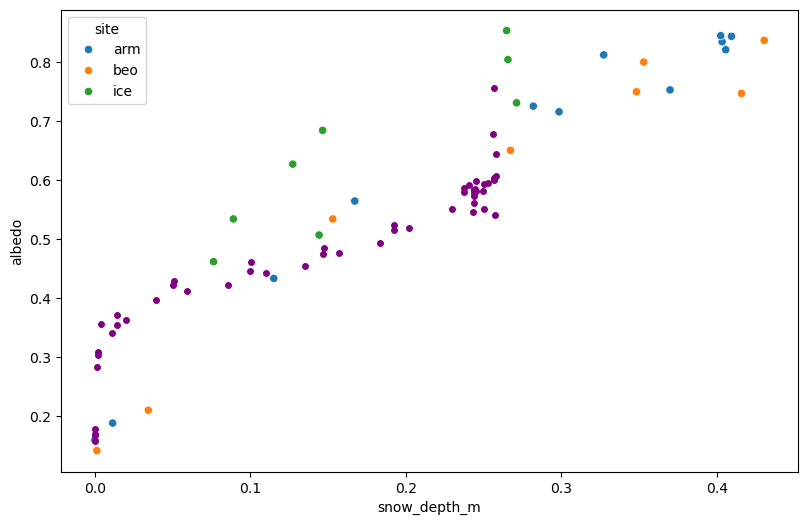

In [19]:
f = plt.figure(figsize=(9.5, 6))

sns.scatterplot(x='snow_depth_m', y='albedo', hue='site', data=df_temp.groupby(level=['site','date_akdt']).mean())#df_temp.reset_index())
plt.scatter(x='SNOWDP', y='albedo', data=df_cafs, color='purple', s=16)


C:\Users\dclemenssewall\AppData\Local\Temp\ipykernel_37952\4128703816.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp['albedo'] = df_temp['reflected_solar_W_m2'] / df_temp['incident_bestestimate_W_m2']


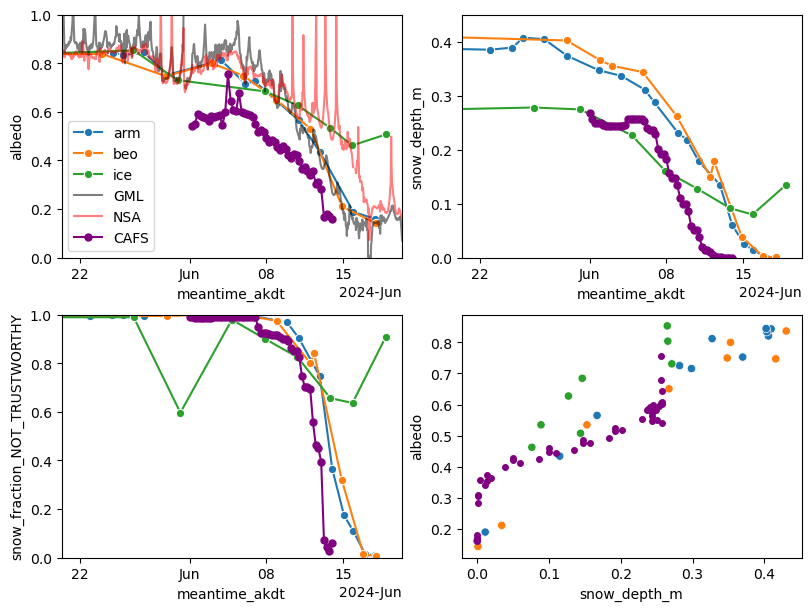

In [20]:
# Compare with CAFS
start_date = pd.Timestamp('2024-05-20T00:00:00-0800')
end_date = pd.Timestamp('2024-06-20T00:00:00-0800')
bare_threshold = 0.05

f, axs = plt.subplots(2, 2, figsize=(8, 6), layout='constrained')

# Albedo
# Line
df_temp = line_date_agg(df, 'albedo')
df_temp = df_temp.query('position != -999.0')
sns.lineplot(data=df_temp.groupby(['site', 'date_akdt']).mean(), 
             x='meantime_akdt', y='albedo', hue='site', ax=axs[0,0],
            marker='o')
# hourly albedo rack
df_temp = df_gml.query("(incident_bestestimate_W_m2_qc==0) and (reflected_solar_W_m2_qc==0)")
df_temp['albedo'] = df_temp['reflected_solar_W_m2'] / df_temp['incident_bestestimate_W_m2']
df_temp = df_temp['albedo'].resample('1h').mean()
df_temp.index = df_temp.index.tz_convert('-0800').rename('timestamp_akdt')
df_temp = df_temp.reset_index()
axs[0,0].plot('timestamp_akdt', 'albedo', data=df_temp, c='k', alpha=0.5)
# NSA albedo
df_temp = df_nsa['albedo'].resample('1h').mean()
df_temp.index = df_temp.index.tz_convert('-0800').rename('timestamp_akdt')
df_temp = df_temp.reset_index()
axs[0,0].plot('timestamp_akdt', 'albedo', data=df_temp, c='r', alpha=0.5)

# CAFS
df_temp = df_cafs['albedo']
df_temp.index = df_temp.index.tz_convert('-0800').rename('timestamp_akdt')
df_temp = df_temp.reset_index()
axs[0,0].plot('timestamp_akdt', 'albedo', data=df_temp, c='purple', marker='o', markersize=5)

axs[0,0].set_xlim([start_date, end_date])
axs[0,0].set_ylim(0, 1.0)
locator = mdates.AutoDateLocator(minticks=3, maxticks=7)
formatter = mdates.ConciseDateFormatter(locator)
axs[0,0].xaxis.set_major_locator(locator)
axs[0,0].xaxis.set_major_formatter(formatter)

handles, labels = axs[0,0].get_legend_handles_labels()
labels[3] = 'GML'
labels[4] = 'NSA'
labels[5] = 'CAFS'
axs[0,0].legend(handles, labels)

# Mean snow depth
# Line
df_temp = line_date_agg(df, 'snow_depth_m')
df_temp = df_temp.query('position != -999.0')
sns.lineplot(data=df_temp.groupby(['site', 'date_akdt']).mean(), 
             x='meantime_akdt', y='snow_depth_m', hue='site', ax=axs[0,1],
            marker='o', legend=False)
# CAFS
df_temp = df_cafs['SNOWDP']
df_temp.index = df_temp.index.tz_convert('-0800').rename('timestamp_akdt')
df_temp = df_temp.reset_index()
axs[0,1].plot('timestamp_akdt', 'SNOWDP', data=df_temp, c='purple', marker='o', markersize=5)

axs[0,1].set_xlim([start_date, end_date])
axs[0,1].set_ylim(0, 0.45)
axs[0,1].xaxis.set_major_locator(locator)
axs[0,1].xaxis.set_major_formatter(formatter)

# Snow fraction
# Line
df_temp = line_date_agg(df, 'snow_depth_m')
df_temp.reset_index(inplace=True)
df_temp.set_index(['site', 'meantime_akdt', 'position'], inplace=True)
df_temp = (df_temp['snow_depth_m'] > bare_threshold).groupby(level=['site', 'meantime_akdt']).mean()
df_temp.rename('snow_fraction_NOT_TRUSTWORTHY', inplace=True)
sns.lineplot(data=df_temp.reset_index(), 
             x='meantime_akdt', y='snow_fraction_NOT_TRUSTWORTHY', hue='site', ax=axs[1,0],
            marker='o', legend=False)
# CAFS
df_temp = df_cafs['FSNO_EFF']
df_temp.index = df_temp.index.tz_convert('-0800').rename('timestamp_akdt')
df_temp = df_temp.reset_index()
axs[1,0].plot('timestamp_akdt', 'FSNO_EFF', data=df_temp, c='purple', marker='o', markersize=5)

axs[1,0].set_xlim([start_date, end_date])
axs[1,0].set_ylim(0, 1.0)
axs[1,0].xaxis.set_major_locator(locator)
axs[1,0].xaxis.set_major_formatter(formatter)

# Albedo vs. snow depth
# Line
df_temp = pd.merge(line_date_agg(df, 'albedo'),
                   line_date_agg(df, 'snow_depth_m'),
                   left_index=True, right_index=True)
sns.scatterplot(x='snow_depth_m', y='albedo', hue='site', legend=False,
                data=df_temp.groupby(level=['site','date_akdt']).mean(), ax=axs[1,1])
# CAFS
axs[1,1].scatter(x='SNOWDP', y='albedo', data=df_cafs, color='purple', s=16)

plt.show()

In [21]:
# Convert w/m2 to m/day of snow melt
def snowmelt_rate(q):
    rhos = 400 # kg/m3
    l_melt = 3.33e5 # J/kg
    s_per_day = 60*60*24

    return q*s_per_day/(rhos*l_melt)

def inv_snowmelt_rate(rate):
    rhos = 400 # kg/m3
    l_melt = 3.33e5 # J/kg
    s_per_day = 60*60*24

    return rate*(rhos*l_melt)/s_per_day

C:\Users\dclemenssewall\AppData\Local\Temp\ipykernel_37952\3556358179.py:61: RuntimeWarning: Second argument 'h' is ambiguous: could be a format string but is in 'data'; using as data.  If it was intended as data, set the format string to an empty string to suppress this warning.  If it was intended as a format string, explicitly pass the x-values as well.  Alternatively, rename the entry in 'data'.
  axs[3].plot('timestamp_utc', 'h', data=df_ecr_temp, c='red', marker='', label='NSA Sensible')


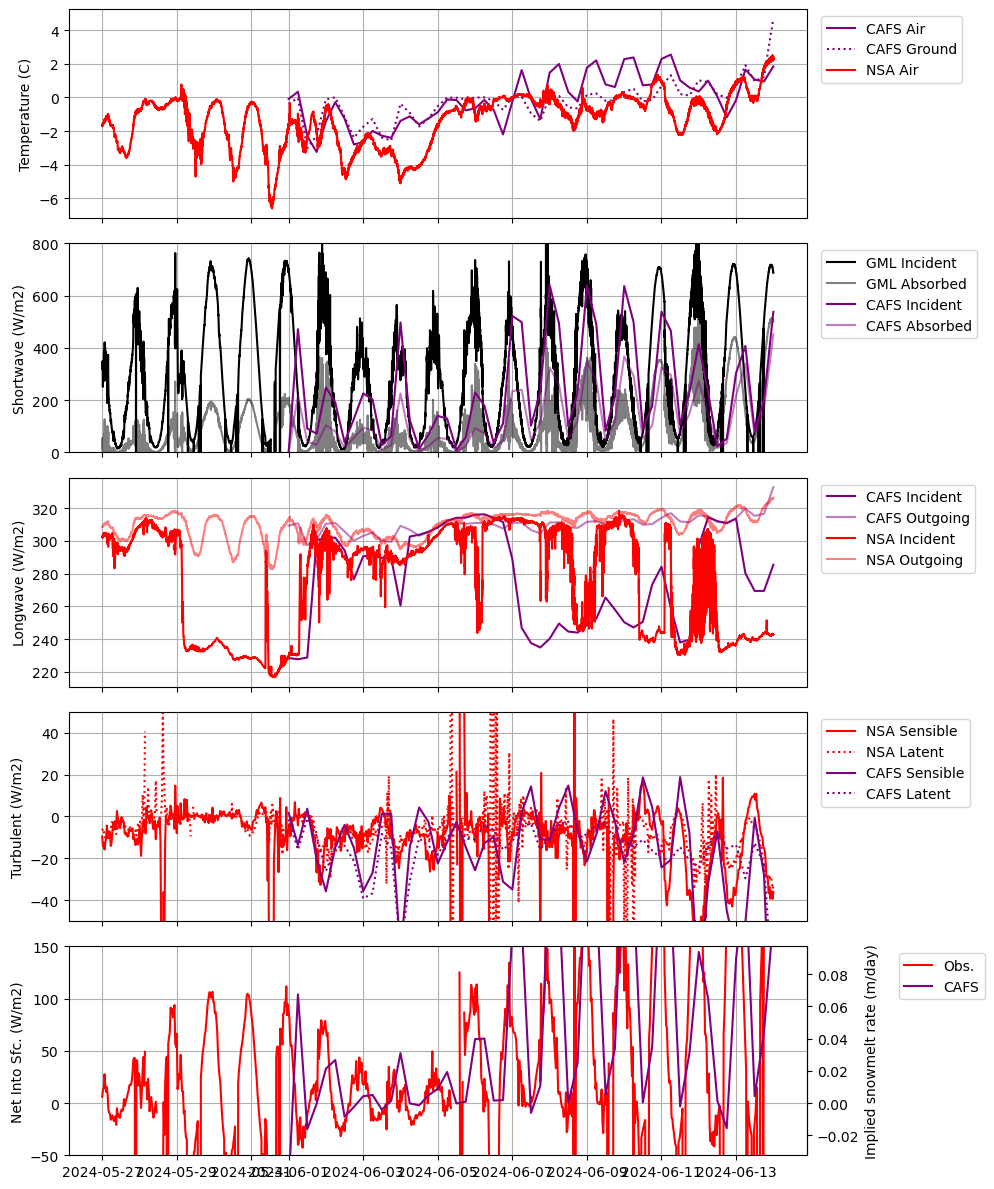

In [259]:
# Examine radiation budgets and air temperature between the model and NSA
emissivity = 0.985
sigma = 5.67037e-8
start = pd.Timestamp('2024-05-27', tz='UTC')
end = pd.Timestamp('2024-06-14', tz='UTC')
df_cafs_temp = df_cafs[['TSA', 'FSDS', 'FSR', 'FLDS', 'TG', 'FSH', 'EFLX_LH_TOT']].reset_index()
df_cafs_temp['TSA'] -= 273.15
df_cafs_temp['FLUS'] = emissivity*sigma*(df_cafs_temp['TG']**4)
df_cafs_temp['TG'] -= 273.15
df_cafs_temp['FSA'] = df_cafs_temp['FSDS'] - df_cafs_temp['FSR']
df_cafs_temp['FSH'] *= -1 #downward sensible heat
df_cafs_temp['EFLX_LH_TOT'] *= -1 #downward latent heat
df_cafs_temp['FLNET'] = df_cafs_temp['FLDS'] - df_cafs_temp['FLUS']
df_cafs_temp['net'] = df_cafs_temp['FSA'] + df_cafs_temp['FLNET'] + df_cafs_temp['FSH'] + df_cafs_temp['EFLX_LH_TOT']

df_gml_temp = df_gml.loc[slice(start, end)].reset_index()
df_gml_temp['absorbed_solar_W_m2'] = df_gml_temp['incident_bestestimate_W_m2'] - df_gml_temp['reflected_solar_W_m2']
df_nsa_temp = df_nsa.loc[slice(start, end)].reset_index()
df_nsa_temp['net_long'] = df_nsa_temp['down_long_hemisp'] - df_nsa_temp['up_long_hemisp']
df_ecr_temp = df_ecr.loc[slice(start, end)].reset_index()
# Change turbulent flux direction to downwards
df_ecr_temp['h'] *= -1
df_ecr_temp['lv_e'] *= -1
df_30min = pd.merge(df_nsa_temp.resample('30min', on='timestamp_utc').mean()['net_long'], 
         df_gml_temp.resample('30min', on='timestamp_utc').mean()['absorbed_solar_W_m2'],
        left_index=True, right_index=True)
df_30min = pd.merge(df_30min, df_ecr_temp[['timestamp_utc', 'h', 'lv_e']], left_index=True, right_on='timestamp_utc')
df_30min['net'] = df_30min['net_long'] + df_30min['absorbed_solar_W_m2'] + df_30min['h'] + df_30min['lv_e']

f, axs = plt.subplots(5, 1, sharex=True, figsize=(10, 12), layout='tight')

# Air temperature
axs[0].plot('timestamp_utc', 'TSA', data=df_cafs_temp, c='purple', marker='', label='CAFS Air')
axs[0].plot('timestamp_utc', 'TG', data=df_cafs_temp, c='purple', linestyle=':', marker='', label='CAFS Ground')
axs[0].plot('timestamp_utc', 'Temp_Air', data=df_nsa_temp, c='red', label='NSA Air')
axs[0].set_ylabel('Temperature (C)')
axs[0].legend(bbox_to_anchor=(1.01, 1))
axs[0].grid()

# Shortwave
axs[1].plot('timestamp_utc', 'incident_bestestimate_W_m2', data=df_gml_temp, c='k', marker='', label='GML Incident')
axs[1].plot('timestamp_utc', 'absorbed_solar_W_m2', data=df_gml_temp, c='k', alpha=0.5, label='GML Absorbed')
axs[1].plot('timestamp_utc', 'FSDS', data=df_cafs_temp, c='purple', marker='', label='CAFS Incident')
axs[1].plot('timestamp_utc', 'FSA', data=df_cafs_temp, c='purple', marker='', alpha=0.5, label='CAFS Absorbed')
axs[1].set_ylim([0, 800])
axs[1].set_ylabel('Shortwave (W/m2)')
axs[1].legend(bbox_to_anchor=(1.01, 1))
axs[1].grid()

# Longwave
axs[2].plot('timestamp_utc', 'FLDS', data=df_cafs_temp, c='purple', marker='', label='CAFS Incident')
axs[2].plot('timestamp_utc', 'FLUS', data=df_cafs_temp, c='purple', marker='', alpha=0.5, label='CAFS Outgoing')

axs[2].plot('timestamp_utc', 'down_long_hemisp', data=df_nsa_temp, c='red', marker='', label='NSA Incident')
axs[2].plot('timestamp_utc', 'up_long_hemisp', data=df_nsa_temp, c='red', marker='', alpha=0.5, label='NSA Outgoing')
axs[2].set_ylabel('Longwave (W/m2)')
axs[2].legend(bbox_to_anchor=(1.01, 1))
axs[2].grid()

# Turbulent
axs[3].plot('timestamp_utc', 'h', data=df_ecr_temp, c='red', marker='', label='NSA Sensible')
axs[3].plot('timestamp_utc', 'lv_e', data=df_ecr_temp, c='red', marker='', linestyle=':', label='NSA Latent')
axs[3].plot('timestamp_utc', 'FSH', data=df_cafs_temp, c='purple', marker='', label='CAFS Sensible')
axs[3].plot('timestamp_utc', 'EFLX_LH_TOT', data=df_cafs_temp, c='purple', marker='', linestyle=':', label='CAFS Latent')
axs[3].set_ylabel('Turbulent (W/m2)')
axs[3].legend(bbox_to_anchor=(1.01, 1))
axs[3].set_ylim([-50, 50])
axs[3].grid()

# Net fluxes
axs[4].plot('timestamp_utc', 'net', data=df_30min, c='red', marker='', label='Obs.')
axs[4].plot('timestamp_utc', 'net', data=df_cafs_temp, c='purple', marker='', label='CAFS')
axs[4].set_ylim([-50, 150])
axs[4].set_ylabel('Net Into Sfc. (W/m2)')
sec_yax = axs[4].secondary_yaxis('right', functions=(snowmelt_rate, inv_snowmelt_rate))
sec_yax.set_ylabel('Implied snowmelt rate (m/day)')
axs[4].legend(bbox_to_anchor=(1.25, 1))
axs[4].grid()

In [215]:
df_gml_temp

,zen,incident_solar_W_m2,incident_solar_W_m2_qc,reflected_solar_W_m2,reflected_solar_W_m2_qc,direct_solar_W_m2,direct_solar_W_m2_qc,diffuse_solar_W_m2,diffuse_solar_W_m2_qc,incident_bestestimate_W_m2,incident_bestestimate_W_m2_qc,absorbed_solar_W_m2
timestamp_utc,,,,,,,,,,,,
2024-01-01 00:00:00+00:00,95.69,-0.7,0,-0.7,0,0.2,0,0.0,0,-0.019829,0,0.680171
2024-01-01 00:01:00+00:00,95.72,-0.7,0,-0.7,0,0.2,0,0.0,0,-0.019933,0,0.680067
2024-01-01 00:02:00+00:00,95.75,-0.7,0,-0.7,0,0.2,0,0.0,0,-0.020038,0,0.679962
2024-01-01 00:03:00+00:00,95.78,-0.7,0,-0.7,0,0.2,0,0.0,0,-0.020142,0,0.679858
2024-01-01 00:04:00+00:00,95.81,-0.7,0,-0.7,0,0.2,0,0.0,0,-0.020246,0,0.679754
...,...,...,...,...,...,...,...,...,...,...,...,...
2024-09-08 23:55:00+00:00,67.63,362.5,0,67.3,0,211.8,0,285.9,0,366.508164,0,299.208164
2024-09-08 23:56:00+00:00,67.67,371.8,0,75.1,0,238.4,0,284.4,0,374.977826,0,299.877826
2024-09-08 23:57:00+00:00,67.70,397.6,0,82.2,0,309.6,0,284.4,0,401.879627,0,319.679627


In [216]:
# Compare cumulative net fluxes with snow melt rates

# !!! Note, 4% of net longwave data is missing, it has been interpolated.

lat_ht_fus = 334000.0 # J/Kg
rhos = 400 # kg/m3
emissivity = 0.985
sigma = 5.67037e-8

mlt_thr = -0.1

def positive_mean(ser, positive=True):
    """
    Sum all positive (or negative) values in a series
    """
    if positive:
        return ser.loc[ser>0].sum()/ser.size
    else:
        return ser.loc[ser<0].sum()/ser.size

# Create net flux dataframe
df_gml_temp = df_gml.copy()
df_gml_temp['absorbed_solar_W_m2'] = df_gml_temp['incident_bestestimate_W_m2'] - df_gml_temp['reflected_solar_W_m2']
df_gml_temp['diffuse_frac'] = df_gml_temp['diffuse_solar_W_m2']/df_gml_temp['incident_bestestimate_W_m2']
df_nsa_temp = df_nsa.copy()
df_nsa_temp['net_long'] = df_nsa_temp['down_long_hemisp'] - df_nsa_temp['up_long_hemisp']
# compute ground temperature
df_nsa_temp['ground_temp_rad_C'] = (df_nsa_temp['up_long_hemisp']/(emissivity*sigma))**(1/4) - 273.15
df_ecr_temp = df_ecr.copy()
# Change turbulent flux direction to downwards
df_ecr_temp['h'] *= -1
df_ecr_temp['lv_e'] *= -1
df_ecr_temp = df_ecr_temp.resample('1min').interpolate(method='time')
df_flux = pd.merge(df_nsa_temp[['net_long', 'ground_temp_rad_C', 'Temp_Air']].interpolate('time'),
                   df_gml_temp['absorbed_solar_W_m2'], left_index=True, right_index=True)
df_flux = pd.merge(df_flux, df_ecr_temp[['h', 'lv_e']], left_index=True, right_index=True)
df_flux['net'] = df_flux['net_long'] + df_flux['absorbed_solar_W_m2'] + df_flux['h'] + df_flux['lv_e']
df_flux['net_radiation'] = df_flux['net_long'] + df_flux['absorbed_solar_W_m2']
df_flux.index = df_flux.index.tz_convert('-0800').rename('timestamp_akdt')

# Create 30 minute dataframe, which is base frequency for ECORR data
df_flux30min = pd.merge(df_nsa_temp.resample('30min').mean()[['net_long', 'ground_temp_rad_C', 'Temp_Air']], 
         df_gml_temp.resample('30min').mean()[['absorbed_solar_W_m2', 'reflected_solar_W_m2', 'incident_bestestimate_W_m2', 'diffuse_frac']],
        left_index=True, right_index=True)
df_flux30min = pd.merge(df_flux30min, df_ecr_temp[['h', 'lv_e']], left_index=True, right_index=True)
df_flux30min['net'] = df_flux30min['net_long'] + df_flux30min['absorbed_solar_W_m2'] + df_flux30min['h'] + df_flux30min['lv_e']
df_flux30min['albedo'] = df_flux30min['reflected_solar_W_m2']/df_flux30min['incident_bestestimate_W_m2']
df_flux30min.index = df_flux30min.index.tz_convert('-0800').rename('timestamp_akdt')

#df_flux30min = df_flux.resample('30min').mean()
df_flux3hour = df_flux30min.resample('3h').mean()

# Create melt dataframe
df_temp = line_date_agg(df, 'snow_depth_m')
df_temp = df_temp.groupby(level=['site', 'date_akdt']).mean().sort_index().reset_index()
df_temp2 = df_temp.copy()
df_temp2.index = df_temp2.index + 1
df_melt = pd.merge(df_temp2, df_temp, left_index=True, right_index=True, suffixes=('_start', '_end'))
df_melt = df_melt.loc[df_melt['site_start'] == df_melt['site_end']]
df_melt['site'] = df_melt['site_start']
df_melt = df_melt.drop(columns=['site_start', 'site_end'])
df_melt['snow_depth_m_delta'] = df_melt['snow_depth_m_end'] - df_melt['snow_depth_m_start']
df_melt['snow_melt_rate_m_per_day'] = -1*df_melt['snow_depth_m_delta'] / (
    (df_melt['meantime_akdt_end'] - df_melt['meantime_akdt_start'])/pd.Timedelta(days=1))
# Add columns for cumulative fluxes and populate
df_melt['cum_pos_1min_kgH2O_m2'] = np.nan
df_melt['cum_1min_kgH2O_m2'] = np.nan
df_melt['cum_mlt_1min_kgH2O_m2'] = np.nan
df_melt['cum_pos_30min_kgH2O_m2'] = np.nan
df_melt['cum_30min_kgH2O_m2'] = np.nan
df_melt['cum_mlt_30min_kgH2O_m2'] = np.nan
df_melt['cum_pos_3hour_kgH2O_m2'] = np.nan
df_melt['cum_3hour_kgH2O_m2'] = np.nan
df_melt['cum_mlt_3hour_kgH2O_m2'] = np.nan
for i in df_melt.index:
    durration_s = (df_melt.at[i,'meantime_akdt_end'] - df_melt.at[i,'meantime_akdt_start'])/pd.Timedelta(seconds=1)
    
    df_temp = df_flux.loc[slice(df_melt.at[i,'meantime_akdt_start'], df_melt.at[i,'meantime_akdt_end'])]
    df_melt.at[i,'cum_1min_kgH2O_m2'] = df_temp['net'].mean()*durration_s/lat_ht_fus
    df_melt.at[i,'cum_pos_1min_kgH2O_m2'] = positive_mean(df_temp['net'])*durration_s/lat_ht_fus
    df_melt.at[i,'cum_mlt_1min_kgH2O_m2'] = (df_temp.loc[df_temp.ground_temp_rad_C>=mlt_thr]['net'].sum()
                                             /df_temp.shape[0])*durration_s/lat_ht_fus

    df_temp = df_flux30min.loc[slice(df_melt.at[i,'meantime_akdt_start'], df_melt.at[i,'meantime_akdt_end'])]
    df_melt.at[i,'cum_30min_kgH2O_m2'] = df_temp['net'].mean()*durration_s/lat_ht_fus
    df_melt.at[i,'cum_pos_30min_kgH2O_m2'] = positive_mean(df_temp['net'])*durration_s/lat_ht_fus
    df_melt.at[i,'cum_mlt_30min_kgH2O_m2'] = (df_temp.loc[df_temp.ground_temp_rad_C>=mlt_thr]['net'].sum()
                                             /df_temp.shape[0])*durration_s/lat_ht_fus

    df_temp = df_flux3hour.loc[slice(df_melt.at[i,'meantime_akdt_start'], df_melt.at[i,'meantime_akdt_end'])]
    df_melt.at[i,'cum_3hour_kgH2O_m2'] = df_temp['net'].mean()*durration_s/lat_ht_fus
    df_melt.at[i,'cum_pos_3hour_kgH2O_m2'] = positive_mean(df_temp['net'])*durration_s/lat_ht_fus
    df_melt.at[i,'cum_mlt_3hour_kgH2O_m2'] = (df_temp.loc[df_temp.ground_temp_rad_C>=mlt_thr]['net'].sum()
                                             /df_temp.shape[0])*durration_s/lat_ht_fus
    
df_melt['snowmelt_kgH2O_m2'] = np.where(df_melt['snow_depth_m_delta']<0, -1*df_melt['snow_depth_m_delta']*rhos, 0)
df_melt['snowmelt_kgH2O_m2_d'] = df_melt['snowmelt_kgH2O_m2'] / (
    (df_melt['meantime_akdt_end'] - df_melt['meantime_akdt_start'])/pd.Timedelta(days=1))

df_melt['cum_1min_kgH2O_m2_d'] = df_melt['cum_1min_kgH2O_m2'] / (
    (df_melt['meantime_akdt_end'] - df_melt['meantime_akdt_start'])/pd.Timedelta(days=1))
df_melt['cum_pos_1min_kgH2O_m2_d'] = df_melt['cum_pos_1min_kgH2O_m2'] / (
    (df_melt['meantime_akdt_end'] - df_melt['meantime_akdt_start'])/pd.Timedelta(days=1))
df_melt['cum_mlt_1min_kgH2O_m2_d'] = df_melt['cum_mlt_1min_kgH2O_m2'] / (
    (df_melt['meantime_akdt_end'] - df_melt['meantime_akdt_start'])/pd.Timedelta(days=1))

df_melt['cum_30min_kgH2O_m2_d'] = df_melt['cum_30min_kgH2O_m2'] / (
    (df_melt['meantime_akdt_end'] - df_melt['meantime_akdt_start'])/pd.Timedelta(days=1))
df_melt['cum_pos_30min_kgH2O_m2_d'] = df_melt['cum_pos_30min_kgH2O_m2'] / (
    (df_melt['meantime_akdt_end'] - df_melt['meantime_akdt_start'])/pd.Timedelta(days=1))
df_melt['cum_mlt_30min_kgH2O_m2_d'] = df_melt['cum_mlt_30min_kgH2O_m2'] / (
    (df_melt['meantime_akdt_end'] - df_melt['meantime_akdt_start'])/pd.Timedelta(days=1))

df_melt['cum_3hour_kgH2O_m2_d'] = df_melt['cum_3hour_kgH2O_m2'] / (
    (df_melt['meantime_akdt_end'] - df_melt['meantime_akdt_start'])/pd.Timedelta(days=1))
df_melt['cum_pos_3hour_kgH2O_m2_d'] = df_melt['cum_pos_3hour_kgH2O_m2'] / (
    (df_melt['meantime_akdt_end'] - df_melt['meantime_akdt_start'])/pd.Timedelta(days=1))
df_melt['cum_mlt_3hour_kgH2O_m2_d'] = df_melt['cum_mlt_3hour_kgH2O_m2'] / (
    (df_melt['meantime_akdt_end'] - df_melt['meantime_akdt_start'])/pd.Timedelta(days=1))

In [153]:
df_melt[['site', 'date_akdt_start', 'snowmelt_kgH2O_m2_d', 'cum_pos_1min_kgH2O_m2_d', 'cum_pos_30min_kgH2O_m2_d', 'cum_pos_3hour_kgH2O_m2_d']]

,site,date_akdt_start,snowmelt_kgH2O_m2_d,cum_pos_1min_kgH2O_m2_d,cum_pos_30min_kgH2O_m2_d,cum_pos_3hour_kgH2O_m2_d
1,arm,2024-04-19 14:24:00,0.171145,3.280060,2.493296,2.079064
2,arm,2024-05-22 14:24:00,0.000000,2.867613,2.478856,2.038112
3,arm,2024-05-24 14:24:00,0.000000,4.285852,2.823742,2.865032
4,arm,2024-05-25 14:24:00,0.614689,3.804330,2.834943,2.592164
5,arm,2024-05-27 14:24:00,5.871238,7.572988,7.314951,5.163716
6,arm,2024-05-29 14:24:00,3.707460,8.097243,7.811531,6.205140
7,arm,2024-06-01 14:24:00,2.057835,4.590624,4.223553,3.697203
8,arm,2024-06-03 14:24:00,4.774007,5.559042,5.789732,5.409523
9,arm,2024-06-05 14:24:00,10.650719,11.112123,11.953980,7.582631
10,arm,2024-06-06 14:24:00,10.514544,14.932509,14.982470,14.413124


Text(0.5, 1.0, '3 hour')

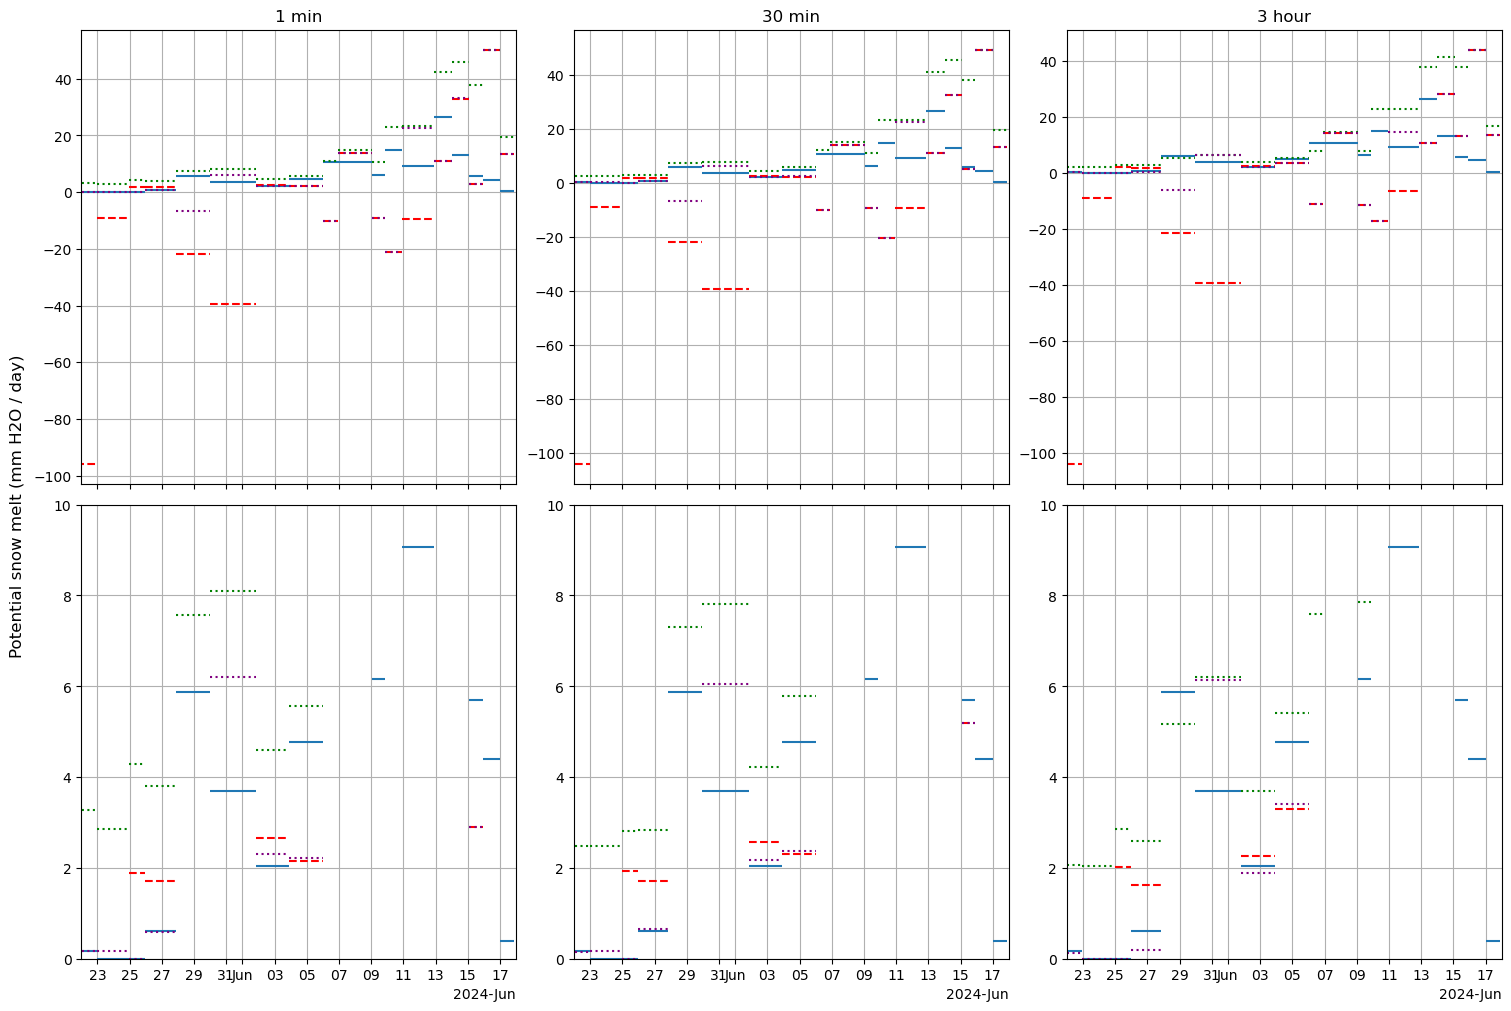

In [154]:
# Plot
locator = mdates.AutoDateLocator(minticks=10, maxticks=15)
formatter = mdates.ConciseDateFormatter(locator)

f, axs = plt.subplots(2, 3, sharex=True, figsize=(15, 10), constrained_layout=True)

# 1 min
axs[0,0].hlines('snowmelt_kgH2O_m2_d', 'meantime_akdt_start', 'meantime_akdt_end', 
              data=df_melt.loc[df_melt.site=='arm'], label='Line',)
axs[0,0].hlines('cum_1min_kgH2O_m2_d', 'meantime_akdt_start', 'meantime_akdt_end', 
              data=df_melt.loc[df_melt.site=='arm'], label='Net', color='red', linestyle='--')
axs[0,0].hlines('cum_pos_1min_kgH2O_m2_d', 'meantime_akdt_start', 'meantime_akdt_end', 
              data=df_melt.loc[df_melt.site=='arm'], label='Positive', color='green', linestyle=':')
axs[0,0].hlines('cum_mlt_1min_kgH2O_m2_d', 'meantime_akdt_start', 'meantime_akdt_end', 
              data=df_melt.loc[df_melt.site=='arm'], label='>0C surf', color='purple', linestyle=':')
axs[0,0].grid()
axs[1,0].hlines('snowmelt_kgH2O_m2_d', 'meantime_akdt_start', 'meantime_akdt_end', 
              data=df_melt.loc[df_melt.site=='arm'], label='Line',)
axs[1,0].hlines('cum_1min_kgH2O_m2_d', 'meantime_akdt_start', 'meantime_akdt_end', 
              data=df_melt.loc[df_melt.site=='arm'], label='Net', color='red', linestyle='--')
axs[1,0].hlines('cum_pos_1min_kgH2O_m2_d', 'meantime_akdt_start', 'meantime_akdt_end', 
              data=df_melt.loc[df_melt.site=='arm'], label='Positive', color='green', linestyle=':')
axs[1,0].hlines('cum_mlt_1min_kgH2O_m2_d', 'meantime_akdt_start', 'meantime_akdt_end', 
              data=df_melt.loc[df_melt.site=='arm'], label='>0C surf', color='purple', linestyle=':')
axs[1,0].set_ylim([0, 10])
axs[1,0].grid()

# 30 min
axs[0,1].hlines('snowmelt_kgH2O_m2_d', 'meantime_akdt_start', 'meantime_akdt_end', 
              data=df_melt.loc[df_melt.site=='arm'], label='Line',)
axs[0,1].hlines('cum_30min_kgH2O_m2_d', 'meantime_akdt_start', 'meantime_akdt_end', 
              data=df_melt.loc[df_melt.site=='arm'], label='Net', color='red', linestyle='--')
axs[0,1].hlines('cum_pos_30min_kgH2O_m2_d', 'meantime_akdt_start', 'meantime_akdt_end', 
              data=df_melt.loc[df_melt.site=='arm'], label='Positive', color='green', linestyle=':')
axs[0,1].hlines('cum_mlt_30min_kgH2O_m2_d', 'meantime_akdt_start', 'meantime_akdt_end', 
              data=df_melt.loc[df_melt.site=='arm'], label='>0C surf', color='purple', linestyle=':')
axs[0,1].grid()
axs[1,1].hlines('snowmelt_kgH2O_m2_d', 'meantime_akdt_start', 'meantime_akdt_end', 
              data=df_melt.loc[df_melt.site=='arm'], label='Line',)
axs[1,1].hlines('cum_30min_kgH2O_m2_d', 'meantime_akdt_start', 'meantime_akdt_end', 
              data=df_melt.loc[df_melt.site=='arm'], label='Net', color='red', linestyle='--')
axs[1,1].hlines('cum_pos_30min_kgH2O_m2_d', 'meantime_akdt_start', 'meantime_akdt_end', 
              data=df_melt.loc[df_melt.site=='arm'], label='Positive', color='green', linestyle=':')
axs[1,1].hlines('cum_mlt_30min_kgH2O_m2_d', 'meantime_akdt_start', 'meantime_akdt_end', 
              data=df_melt.loc[df_melt.site=='arm'], label='>0C surf', color='purple', linestyle=':')
axs[1,1].set_ylim([0, 10])
axs[1,1].grid()

# 3hour
axs[0,2].hlines('snowmelt_kgH2O_m2_d', 'meantime_akdt_start', 'meantime_akdt_end', 
              data=df_melt.loc[df_melt.site=='arm'], label='Line',)
axs[0,2].hlines('cum_3hour_kgH2O_m2_d', 'meantime_akdt_start', 'meantime_akdt_end', 
              data=df_melt.loc[df_melt.site=='arm'], label='Net', color='red', linestyle='--')
axs[0,2].hlines('cum_pos_3hour_kgH2O_m2_d', 'meantime_akdt_start', 'meantime_akdt_end', 
              data=df_melt.loc[df_melt.site=='arm'], label='Positive', color='green', linestyle=':')
axs[0,2].hlines('cum_mlt_3hour_kgH2O_m2_d', 'meantime_akdt_start', 'meantime_akdt_end', 
              data=df_melt.loc[df_melt.site=='arm'], label='>0C surf', color='purple', linestyle=':')
axs[0,2].grid()
axs[1,2].hlines('snowmelt_kgH2O_m2_d', 'meantime_akdt_start', 'meantime_akdt_end', 
              data=df_melt.loc[df_melt.site=='arm'], label='Line',)
axs[1,2].hlines('cum_3hour_kgH2O_m2_d', 'meantime_akdt_start', 'meantime_akdt_end', 
              data=df_melt.loc[df_melt.site=='arm'], label='Net', color='red', linestyle='--')
axs[1,2].hlines('cum_pos_3hour_kgH2O_m2_d', 'meantime_akdt_start', 'meantime_akdt_end', 
              data=df_melt.loc[df_melt.site=='arm'], label='Positive', color='green', linestyle=':')
axs[1,2].hlines('cum_mlt_3hour_kgH2O_m2_d', 'meantime_akdt_start', 'meantime_akdt_end', 
              data=df_melt.loc[df_melt.site=='arm'], label='>0C surf', color='purple', linestyle=':')
axs[1,2].set_ylim([0, 10])
axs[1,2].grid()


axs[1,0].set_xlim([pd.Timestamp('2024-05-22'), 
          pd.Timestamp('2024-06-18')])
axs[1,0].xaxis.set_major_locator(locator)
axs[1,0].xaxis.set_major_formatter(formatter)
axs[1,1].set_xlim([pd.Timestamp('2024-05-22'), 
          pd.Timestamp('2024-06-18')])
axs[1,1].xaxis.set_major_locator(locator)
axs[1,1].xaxis.set_major_formatter(formatter)
axs[1,2].set_xlim([pd.Timestamp('2024-05-22'), 
          pd.Timestamp('2024-06-18')])
axs[1,2].xaxis.set_major_locator(locator)
axs[1,2].xaxis.set_major_formatter(formatter)

f.supylabel('Potential snow melt (mm H2O / day)')
axs[0,0].set_title('1 min')
axs[0,1].set_title('30 min')
axs[0,2].set_title('3 hour')


In [233]:
df.xs(('arm', 'line', 'albedo'), level=('site', 'location', 'variable')).reset_index

,timestamp_akdt,position,repetition,wavelength,value
0,2024-04-19 13:06:00-08:00,0.0,1.0,NaN,0.824532
1,2024-04-19 13:09:00-08:00,5.0,1.0,NaN,0.840743
2,2024-04-19 13:10:00-08:00,10.0,1.0,NaN,0.805988
3,2024-04-19 13:11:00-08:00,15.0,1.0,NaN,0.818494
4,2024-04-19 13:12:00-08:00,20.0,1.0,NaN,0.807242
...,...,...,...,...,...
625,2024-06-17 13:21:00-08:00,20.0,1.0,NaN,0.169065
626,2024-06-17 13:22:00-08:00,15.0,1.0,NaN,0.175783
627,2024-06-17 13:22:00-08:00,10.0,1.0,NaN,0.176164
628,2024-06-17 13:23:00-08:00,5.0,1.0,NaN,0.113924


In [264]:
(df_flux30min['Temp_Air'].rolling(window=48).median().loc[
                  pd.Timestamp('2024-05-22',tz='-0800'):]>-0.1).idxmax()


Timestamp('2024-06-06 21:00:00-0800', tz='UTC-08:00')

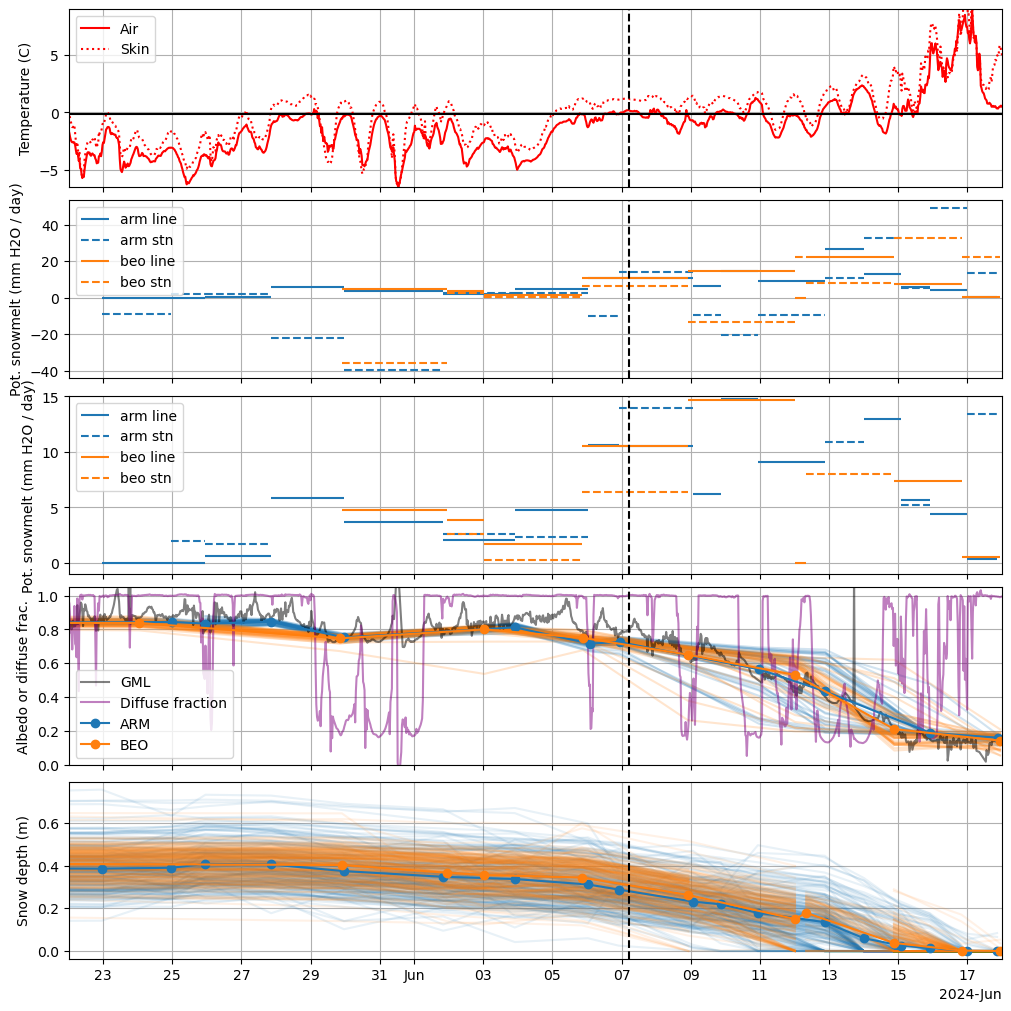

In [249]:
# Plot comparison of albedo, snowmelt rate and subsurface energy absorbed
locator = mdates.AutoDateLocator(minticks=10, maxticks=15)
formatter = mdates.ConciseDateFormatter(locator)

f, axs = plt.subplots(5, 1, sharex=True, figsize=(10, 10), constrained_layout=True)

start = pd.Timestamp('2024-05-22')
end = pd.Timestamp('2024-06-18')

df_temp = df_melt.loc[(df_melt.date_akdt_start>=start) & (df_melt.date_akdt_end<=end)]

df_albedo = line_date_agg(df, 'albedo')
df_albedo = df_albedo.query('position != -999.0')
df_snow = line_date_agg(df, 'snow_depth_m')
df_snow = df_snow.query('position != -999.0')
mlt_dt_persson = (df_flux30min['Temp_Air'].rolling(window=48).median().loc[
                  pd.Timestamp('2024-05-22',tz='-0800'):]>-0.1).idxmax()

# Air temperature and albedo
axs[0].plot(df_flux30min.Temp_Air, color='red', label='Air')
axs[0].plot(df_flux30min.ground_temp_rad_C, color='red', label='Skin', linestyle=':')
axs[0].axhline(y=-0.1, color='k')
axs[0].axvline(x=mlt_dt_persson, color='k', linestyle='--')

axs[0].set_ylabel('Temperature (C)')
axs[0].legend()
axs[0].set_ylim([-6.5, 9])
axs[0].grid()

# Snowmelt and absorbed energy
site = 'arm'
color = 'tab:blue'
axs[1].hlines('snowmelt_kgH2O_m2_d', 'meantime_akdt_start', 'meantime_akdt_end', 
              data=df_temp.loc[df_temp.site==site], label=site + ' line', color=color)
axs[1].hlines('cum_30min_kgH2O_m2_d', 'meantime_akdt_start', 'meantime_akdt_end', 
              data=df_temp.loc[df_temp.site==site], label=site + ' stn', color=color, linestyle='--')
axs[2].hlines('snowmelt_kgH2O_m2_d', 'meantime_akdt_start', 'meantime_akdt_end', 
              data=df_temp.loc[df_temp.site==site], label=site + ' line', color=color)
axs[2].hlines('cum_30min_kgH2O_m2_d', 'meantime_akdt_start', 'meantime_akdt_end', 
              data=df_temp.loc[df_temp.site==site], label=site + ' stn', color=color, linestyle='--')

site = 'beo'
color = 'tab:orange'
axs[1].hlines('snowmelt_kgH2O_m2_d', 'meantime_akdt_start', 'meantime_akdt_end', 
              data=df_temp.loc[df_temp.site==site], label=site + ' line', color=color)
axs[1].hlines('cum_30min_kgH2O_m2_d', 'meantime_akdt_start', 'meantime_akdt_end', 
              data=df_temp.loc[df_temp.site==site], label=site + ' stn', color=color, linestyle='--')
axs[2].hlines('snowmelt_kgH2O_m2_d', 'meantime_akdt_start', 'meantime_akdt_end', 
              data=df_temp.loc[df_temp.site==site], label=site + ' line', color=color)
axs[2].hlines('cum_30min_kgH2O_m2_d', 'meantime_akdt_start', 'meantime_akdt_end', 
              data=df_temp.loc[df_temp.site==site], label=site + ' stn', color=color, linestyle='--')

axs[1].axvline(x=mlt_dt_persson, color='k', linestyle='--')
axs[2].axvline(x=mlt_dt_persson, color='k', linestyle='--')

axs[1].set_ylabel('Pot. snowmelt (mm H2O / day)')
axs[2].set_ylabel('Pot. snowmelt (mm H2O / day)')
axs[1].grid()
axs[1].legend(loc='upper left')
axs[2].set_ylim([-1, 15])
axs[2].grid()
axs[2].legend(loc='upper left')

# Plot albedo
df_alb_wide = df_albedo.xs('arm', level='site').reset_index().drop(columns='date_akdt').pivot(columns='position', index='meantime_akdt')
axs[3].plot(df_alb_wide, color='tab:blue', alpha=0.2)
df_alb_wide = df_albedo.xs('beo', level='site').reset_index().drop(columns='date_akdt').pivot(columns='position', index='meantime_akdt')
axs[3].plot(df_alb_wide, color='tab:orange', alpha=0.2)
axs[3].plot(df_flux30min['albedo'].loc[df_flux30min['albedo']>=0], color='k', alpha=0.5, label='GML')
axs[3].plot(df_flux30min['diffuse_frac'], color='purple', alpha=0.5, label='Diffuse fraction')
axs[3].plot('meantime_akdt', 'albedo', data=df_albedo.xs('arm', level='site').groupby('date_akdt').mean(),
            color='tab:blue', marker='o', label='ARM')
axs[3].plot('meantime_akdt', 'albedo', data=df_albedo.xs('beo', level='site').groupby('date_akdt').mean(),
            color='tab:orange', marker='o', label='BEO')
axs[3].legend(loc='lower left')
axs[3].axvline(x=mlt_dt_persson, color='k', linestyle='--')

axs[3].set_ylabel('Albedo or diffuse frac.')
axs[3].set_ylim([0, 1.05])
axs[3].grid()

# Plot snow depth
df_sno_wide = df_snow.xs('arm', level='site').reset_index().drop(columns='date_akdt').pivot(columns='position', index='meantime_akdt')
axs[4].plot(df_sno_wide, color='tab:blue', alpha=0.1)
df_sno_wide = df_snow.xs('beo', level='site').reset_index().drop(columns='date_akdt').pivot(columns='position', index='meantime_akdt')
axs[4].plot(df_sno_wide, color='tab:orange', alpha=0.1)
axs[4].plot('meantime_akdt', 'snow_depth_m', data=df_snow.xs('arm', level='site').groupby('date_akdt').mean(),
            color='tab:blue', marker='o', label='ARM')
axs[4].plot('meantime_akdt', 'snow_depth_m', data=df_snow.xs('beo', level='site').groupby('date_akdt').mean(),
            color='tab:orange', marker='o', label='BEO')
axs[4].axvline(x=mlt_dt_persson, color='k', linestyle='--')
axs[4].grid()
axs[4].set_ylabel('Snow depth (m)')

axs[4].set_xlim([start, end])
axs[4].xaxis.set_major_locator(locator)
axs[4].xaxis.set_major_formatter(formatter)

In [254]:
df_temp = df_snow.xs('arm', level='site').groupby('date_akdt').mean().reset_index(drop=True).set_index('meantime_akdt')
#df_temp.loc[mlt_dt_persson]
df_temp.max

,snow_depth_m
meantime_akdt,
2024-04-19 11:10:25.287014912-08:00,0.399522
2024-05-22 14:59:04.833731584-08:00,0.385335
2024-05-24 15:14:57.820348416-08:00,0.389368
2024-05-25 15:02:19.848009984-08:00,0.407756
2024-05-27 12:39:41.045423104-08:00,0.404835
2024-05-29 15:13:32.946716416-08:00,0.373910
2024-06-01 12:05:43.560596992-08:00,0.347313
2024-06-03 13:52:46.845572096-08:00,0.336642
2024-06-05 16:31:55.483681536-08:00,0.311453


In [255]:
1 - 0.287/0.408

0.29656862745098045

In [256]:
df_albedo.xs('arm', level='site').groupby('date_akdt').mean()

,albedo,meantime_akdt
date_akdt,,
2024-04-19 14:24:00,0.821019,2024-04-19 13:27:57.073170688-08:00
2024-05-24 14:24:00,0.843656,2024-05-24 15:58:05.714285824-08:00
2024-05-25 14:24:00,0.834529,2024-05-25 14:57:23.414634240-08:00
2024-05-27 14:24:00,0.844855,2024-05-27 12:32:21.951219456-08:00
2024-05-29 14:24:00,0.752966,2024-05-29 15:30:24.878048768-08:00
2024-06-03 14:24:00,0.812294,2024-06-03 13:47:57.209302528-08:00
2024-06-05 14:24:00,0.716293,2024-06-05 17:58:36.774193664-08:00
2024-06-06 14:24:00,0.725462,2024-06-06 14:40:39.512195072-08:00
2024-06-10 14:24:00,0.564789,2024-06-10 15:15:26.341463552-08:00


In [257]:
(1-0.753)/(1-0.845)

1.593548387096774

In [258]:
(1-0.812)/(1-0.845)

1.2129032258064512

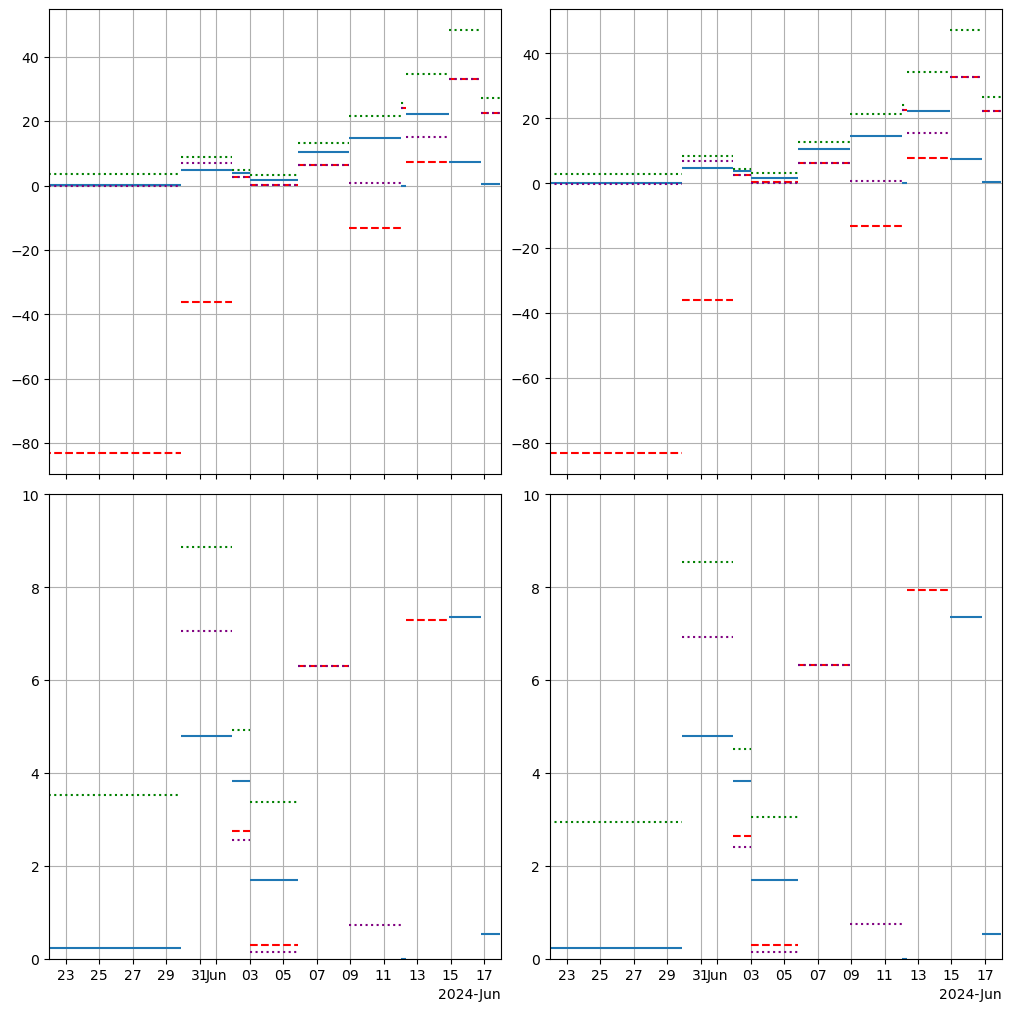

In [137]:
# Plot
site = 'beo'

locator = mdates.AutoDateLocator(minticks=10, maxticks=15)
formatter = mdates.ConciseDateFormatter(locator)

f, axs = plt.subplots(2, 2, sharex=True, figsize=(10, 10), constrained_layout=True)

# 1 min
axs[0,0].hlines('snowmelt_kgH2O_m2_d', 'meantime_akdt_start', 'meantime_akdt_end', 
              data=df_melt.loc[df_melt.site==site], label='Line',)
axs[0,0].hlines('cum_1min_kgH2O_m2_d', 'meantime_akdt_start', 'meantime_akdt_end', 
              data=df_melt.loc[df_melt.site==site], label='Net', color='red', linestyle='--')
axs[0,0].hlines('cum_pos_1min_kgH2O_m2_d', 'meantime_akdt_start', 'meantime_akdt_end', 
              data=df_melt.loc[df_melt.site==site], label='Positive', color='green', linestyle=':')
axs[0,0].hlines('cum_mlt_1min_kgH2O_m2_d', 'meantime_akdt_start', 'meantime_akdt_end', 
              data=df_melt.loc[df_melt.site==site], label='>0C surf', color='purple', linestyle=':')
axs[0,0].grid()
axs[1,0].hlines('snowmelt_kgH2O_m2_d', 'meantime_akdt_start', 'meantime_akdt_end', 
              data=df_melt.loc[df_melt.site==site], label='Line',)
axs[1,0].hlines('cum_1min_kgH2O_m2_d', 'meantime_akdt_start', 'meantime_akdt_end', 
              data=df_melt.loc[df_melt.site==site], label='Net', color='red', linestyle='--')
axs[1,0].hlines('cum_pos_1min_kgH2O_m2_d', 'meantime_akdt_start', 'meantime_akdt_end', 
              data=df_melt.loc[df_melt.site==site], label='Positive', color='green', linestyle=':')
axs[1,0].hlines('cum_mlt_1min_kgH2O_m2_d', 'meantime_akdt_start', 'meantime_akdt_end', 
              data=df_melt.loc[df_melt.site==site], label='>0C surf', color='purple', linestyle=':')
axs[1,0].set_ylim([0, 10])
axs[1,0].grid()

# 30 min
axs[0,1].hlines('snowmelt_kgH2O_m2_d', 'meantime_akdt_start', 'meantime_akdt_end', 
              data=df_melt.loc[df_melt.site==site], label='Line',)
axs[0,1].hlines('cum_30min_kgH2O_m2_d', 'meantime_akdt_start', 'meantime_akdt_end', 
              data=df_melt.loc[df_melt.site==site], label='Net', color='red', linestyle='--')
axs[0,1].hlines('cum_pos_30min_kgH2O_m2_d', 'meantime_akdt_start', 'meantime_akdt_end', 
              data=df_melt.loc[df_melt.site==site], label='Positive', color='green', linestyle=':')
axs[0,1].hlines('cum_mlt_30min_kgH2O_m2_d', 'meantime_akdt_start', 'meantime_akdt_end', 
              data=df_melt.loc[df_melt.site==site], label='>0C surf', color='purple', linestyle=':')
axs[0,1].grid()
axs[1,1].hlines('snowmelt_kgH2O_m2_d', 'meantime_akdt_start', 'meantime_akdt_end', 
              data=df_melt.loc[df_melt.site==site], label='Line',)
axs[1,1].hlines('cum_30min_kgH2O_m2_d', 'meantime_akdt_start', 'meantime_akdt_end', 
              data=df_melt.loc[df_melt.site==site], label='Net', color='red', linestyle='--')
axs[1,1].hlines('cum_pos_30min_kgH2O_m2_d', 'meantime_akdt_start', 'meantime_akdt_end', 
              data=df_melt.loc[df_melt.site==site], label='Positive', color='green', linestyle=':')
axs[1,1].hlines('cum_mlt_30min_kgH2O_m2_d', 'meantime_akdt_start', 'meantime_akdt_end', 
              data=df_melt.loc[df_melt.site==site], label='>0C surf', color='purple', linestyle=':')
axs[1,1].set_ylim([0, 10])
axs[1,1].grid()



axs[1,0].set_xlim([pd.Timestamp('2024-05-22'), 
          pd.Timestamp('2024-06-18')])
axs[1,0].xaxis.set_major_locator(locator)
axs[1,0].xaxis.set_major_formatter(formatter)
axs[1,1].set_xlim([pd.Timestamp('2024-05-22'), 
          pd.Timestamp('2024-06-18')])
axs[1,1].xaxis.set_major_locator(locator)
axs[1,1].xaxis.set_major_formatter(formatter)

In [74]:
df_melt[['site', 'meantime_akdt_start', 'meantime_akdt_end', 'snowmelt_kgH2O_m2', 'cum_1min_kgH2O_m2', 'cum_pos_1min_kgH2O_m2']]

,site,meantime_akdt_start,meantime_akdt_end,snowmelt_kgH2O_m2,cum_1min_kgH2O_m2,cum_pos_1min_kgH2O_m2
1,arm,2024-04-19 11:10:25.287014912-08:00,2024-05-22 14:59:04.833731584-08:00,5.674955,-3175.698168,108.763603
2,arm,2024-05-22 14:59:04.833731584-08:00,2024-05-24 15:14:57.820348416-08:00,0.000000,-18.164503,5.765097
3,arm,2024-05-24 15:14:57.820348416-08:00,2024-05-25 15:02:19.848009984-08:00,0.000000,1.887560,4.250137
4,arm,2024-05-25 15:02:19.848009984-08:00,2024-05-27 12:39:41.045423104-08:00,1.168488,3.264589,7.230868
5,arm,2024-05-27 12:39:41.045423104-08:00,2024-05-29 15:13:32.946716416-08:00,12.369821,-46.341665,15.955864
6,arm,2024-05-29 15:13:32.946716416-08:00,2024-06-01 12:05:43.560596992-08:00,10.638806,-113.268223,23.234590
7,arm,2024-06-01 12:05:43.560596992-08:00,2024-06-03 13:52:46.845572096-08:00,4.268657,5.537800,9.522358
8,arm,2024-06-03 13:52:46.845572096-08:00,2024-06-05 16:31:55.483681536-08:00,10.075622,4.548901,11.731896
9,arm,2024-06-05 16:31:55.483681536-08:00,2024-06-06 14:07:58.912785920-08:00,9.586070,-9.149258,10.000910
10,arm,2024-06-06 14:07:58.912785920-08:00,2024-06-08 17:34:32.286119424-08:00,22.537313,29.904357,32.011566


In [84]:
# Compare arm incident with GML incident
# Shifting the field obs forward 1 minute slightly improves alignment
offset = pd.Timedelta(1, 'min')

df_temp = df_gml.query("incident_solar_W_m2_qc==0")
df_temp.index = df_temp.index.tz_convert('-0800').rename('timestamp_akdt')
df_temp = df_temp[['incident_solar_W_m2', 'incident_bestestimate_W_m2', 'direct_solar_W_m2', 'diffuse_solar_W_m2', 'zen']]
df_temp2 = df.xs(('arm', 'incident_solar_W_m2'), level=('site', 'variable')).droplevel(['location', 'position', 'repetition', 'wavelength'])
df_temp2 = df_temp2.rename(columns={'value': 'salvo_arm_incident'})
df_temp2 = df_temp2.reset_index()
df_temp2['timestamp_akdt'] += offset
df_temp2 = df_temp2.set_index('timestamp_akdt')
df_temp3 = df_nsa.copy()
df_temp3.index = df_temp3.index.tz_convert('-0800').rename('timestamp_akdt')
df_temp3 = df_temp3['BestEstimate_down_short_hemisp'].rename('nsa_incident')

df_comp = df_temp2.join(df_temp)
df_comp = df_comp.join(df_temp3)
df_comp['diff_gml_be'] = df_comp['salvo_arm_incident'] - df_comp['incident_bestestimate_W_m2']
df_comp['diff_nsa'] = df_comp['salvo_arm_incident'] - df_comp['nsa_incident']

df_comp['diff_gml'] = df_comp['salvo_arm_incident'] - df_comp['incident_solar_W_m2']
df_comp['diff_gml_be'] = df_comp['salvo_arm_incident'] - df_comp['incident_bestestimate_W_m2']
df_comp['diff_nsa'] = df_comp['salvo_arm_incident'] - df_comp['nsa_incident']
df_comp['diff_gml_nsa'] = df_comp['incident_bestestimate_W_m2'] - df_comp['nsa_incident']

df_comp['diffuse_frac'] = df_comp['diffuse_solar_W_m2']/df_comp['incident_bestestimate_W_m2']

In [85]:
df_comp['diff_gml'].describe()

count    678.000000
mean      11.210383
std       35.748760
min     -253.800000
25%        6.460000
50%       13.870000
75%       19.307500
max      210.330000
Name: diff_gml, dtype: float64

In [86]:
df_comp['diff_gml_be'].describe()

count    678.000000
mean       0.642091
std       35.346406
min     -239.690515
25%       -6.040979
50%        3.243192
75%        8.861646
max      209.964807
Name: diff_gml_be, dtype: float64

In [87]:
df_comp['diff_gml_nsa'].describe()

count    678.000000
mean      -1.785547
std       28.715068
min     -208.216921
25%       -6.084250
50%       -1.618971
75%        4.810020
max      198.640625
Name: diff_gml_nsa, dtype: float64

In [88]:
df_comp.mean()

salvo_arm_incident            556.149027
incident_solar_W_m2           544.938643
incident_bestestimate_W_m2    555.506935
direct_solar_W_m2             405.871681
diffuse_solar_W_m2            306.739971
zen                            52.271445
nsa_incident                  557.292480
diff_gml_be                     0.642091
diff_nsa                       -1.143455
diff_gml                       11.210383
diff_gml_nsa                   -1.785547
diffuse_frac                    0.617994
dtype: float64

In [89]:
# Median Absolute Deviation
print('Diff GML Median Absolute Deviation:')
print(df_comp['diff_gml_be'].abs().median())
print('equivalent St. Dev. for normal distribution:')
print(df_comp['diff_gml_be'].abs().median()*1.4826)

Diff GML Median Absolute Deviation:
7.777859989486785
equivalent St. Dev. for normal distribution:
11.531455220413108


In [90]:
# Median Absolute Deviation
print('Diff GML NSA Median Absolute Deviation:')
print(df_comp['diff_gml_nsa'].abs().median())
print('equivalent St. Dev. for normal distribution:')
print(df_comp['diff_gml_nsa'].abs().median()*1.4826)

Diff GML NSA Median Absolute Deviation:
5.661461705453348
equivalent St. Dev. for normal distribution:
8.393683124505134


In [91]:
np.sqrt((df_comp['diff_gml_be'].abs().median()*1.4826)**2 - (df_comp['diff_gml_nsa'].abs().median()*1.4826)**2)#/df_comp.salvo_arm_incident.mean()

7.906993303765371

In [92]:
df_comp['diff_nsa'].describe()

count    678.000000
mean      -1.143455
std       39.504146
min     -428.670264
25%       -7.978908
50%       -0.323258
75%       10.259686
max      168.489025
Name: diff_nsa, dtype: float64

Text(0.5, 0, 'salvo-gml incident (W/m2')

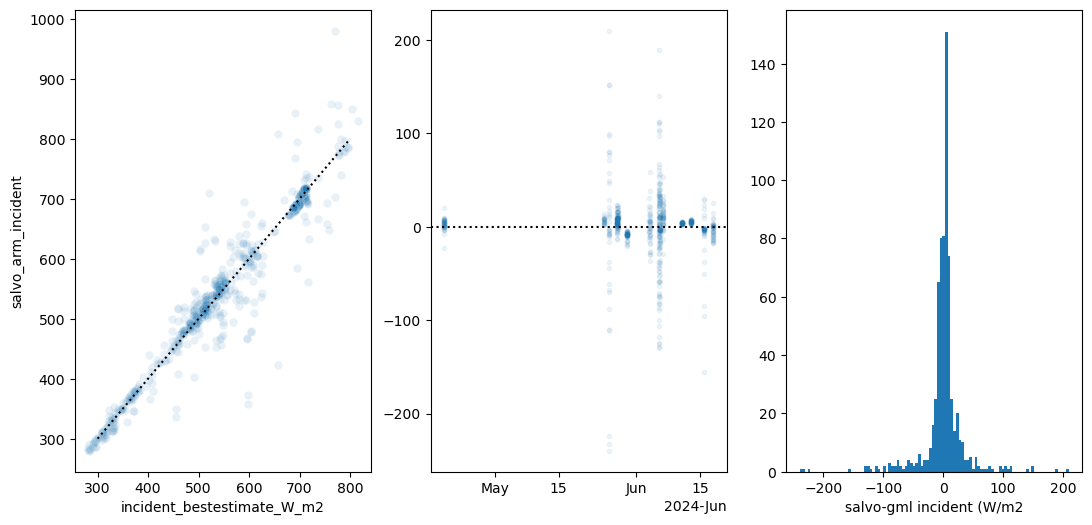

In [93]:
f, axs = plt.subplots(1, 3, figsize=(13, 6))

sns.scatterplot(data=df_comp, x='incident_bestestimate_W_m2', y='salvo_arm_incident', ax=axs[0], alpha=0.1)
axs[0].plot([300, 800], [300, 800], 'k:')

axs[1].plot(df_comp['diff_gml_be'], marker='.', linestyle='', alpha=0.07)
axs[1].axhline(y=0, color='k', linestyle=':')

locator = mdates.AutoDateLocator(minticks=3, maxticks=7)
formatter = mdates.ConciseDateFormatter(locator)
axs[1].xaxis.set_major_locator(locator)
axs[1].xaxis.set_major_formatter(formatter)

axs[2].hist(df_comp['diff_gml_be'], bins=100)
axs[2].set_xlabel('salvo-gml incident (W/m2')

Text(0.5, 0, 'salvo-nsa incident (W/m2')

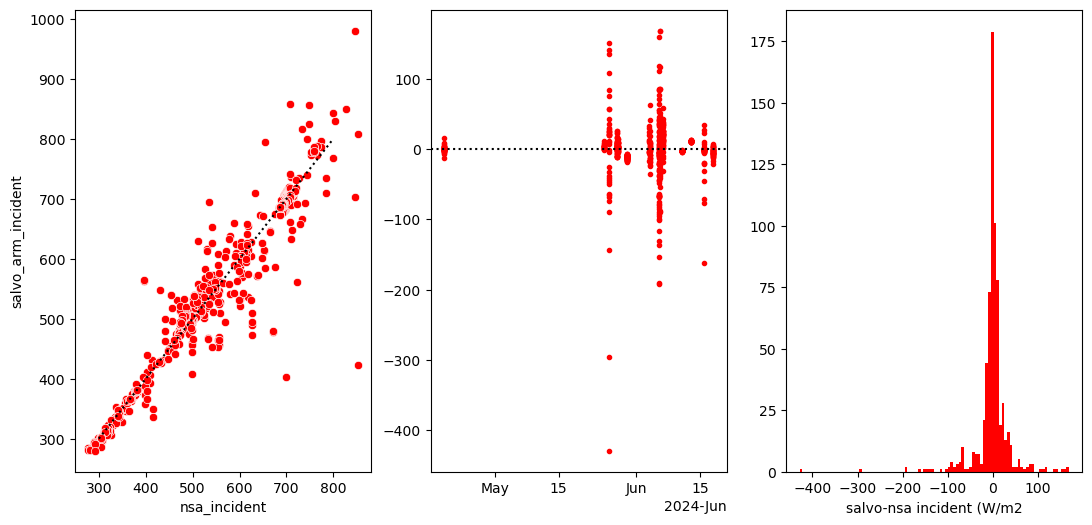

In [94]:
f, axs = plt.subplots(1, 3, figsize=(13, 6))

sns.scatterplot(data=df_comp, x='nsa_incident', y='salvo_arm_incident', ax=axs[0], color='r')
axs[0].plot([300, 800], [300, 800], 'k:')

axs[1].plot(df_comp['diff_nsa'], marker='.', linestyle='', color='r')
axs[1].axhline(y=0, color='k', linestyle=':')

locator = mdates.AutoDateLocator(minticks=3, maxticks=7)
formatter = mdates.ConciseDateFormatter(locator)
axs[1].xaxis.set_major_locator(locator)
axs[1].xaxis.set_major_formatter(formatter)

axs[2].hist(df_comp['diff_nsa'], bins=100, color='r')
axs[2].set_xlabel('salvo-nsa incident (W/m2')

Text(0.5, 0, 'Incident GML (W/m2)')

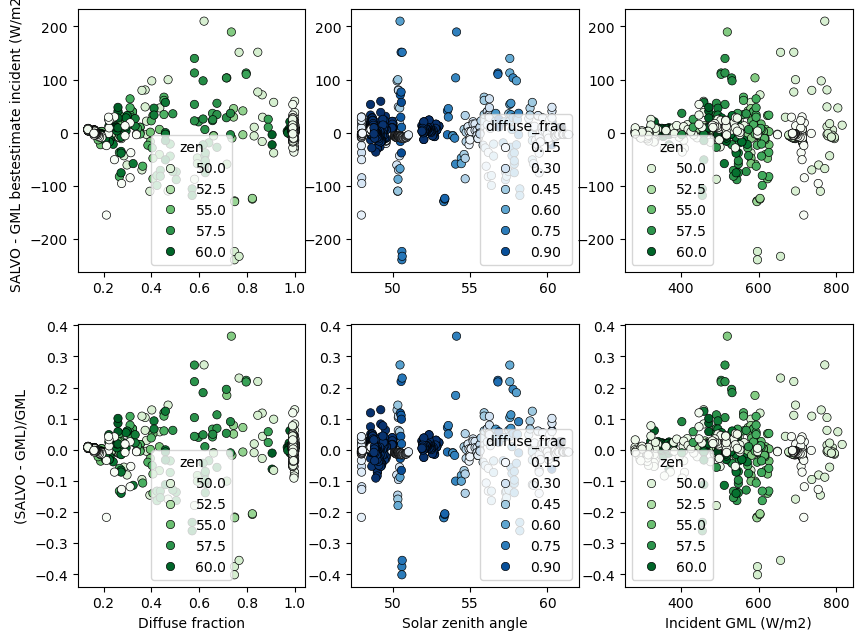

In [95]:
# Examine incident biases as a function of dir/diffuse fraction and zenith angle
df_comp['diff_gml_be_ratio'] = df_comp['diff_gml_be']/df_comp['incident_bestestimate_W_m2']

f, axs = plt.subplots(2, 3, figsize=(10, 7.5))
sns.scatterplot(x='diffuse_frac', y='diff_gml_be', hue='zen', data=df_comp, alpha=1, ax=axs[0,0], palette='Greens', edgecolor='k')
sns.scatterplot(hue='diffuse_frac', y='diff_gml_be', x='zen', data=df_comp, alpha=1, ax=axs[0,1], palette='Blues', edgecolor='k')
sns.scatterplot(hue='zen', y='diff_gml_be', x='incident_bestestimate_W_m2', data=df_comp, alpha=1, ax=axs[0,2], palette='Greens', edgecolor='k')

sns.scatterplot(x='diffuse_frac', y='diff_gml_be_ratio', hue='zen', data=df_comp, alpha=1, ax=axs[1,0], palette='Greens', edgecolor='k')
sns.scatterplot(hue='diffuse_frac', y='diff_gml_be_ratio', x='zen', data=df_comp, alpha=1, ax=axs[1,1], palette='Blues', edgecolor='k')
sns.scatterplot(hue='zen', y='diff_gml_be_ratio', x='incident_bestestimate_W_m2', data=df_comp, alpha=1, ax=axs[1,2], palette='Greens', edgecolor='k')

axs[0,0].set_ylabel('SALVO - GML bestestimate incident (W/m2)')
axs[0,1].set_ylabel('')
axs[0,2].set_ylabel('')
axs[0,0].set_xlabel('')
axs[0,1].set_xlabel('')
axs[0,2].set_xlabel('')

axs[1,0].set_ylabel('(SALVO - GML)/GML')
axs[1,1].set_ylabel('')
axs[1,2].set_ylabel('')

axs[1,0].set_xlabel('Diffuse fraction')
axs[1,1].set_xlabel('Solar zenith angle')
axs[1,2].set_xlabel('Incident GML (W/m2)')


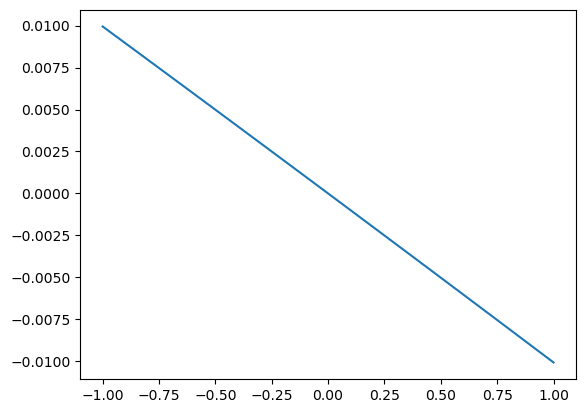

In [96]:
def calc_inc_err(dtheta, sza, diff_frac):
    return (1 - diff_frac)*(np.cos(dtheta+sza) - np.cos(sza))

sza = 55
dtheta = np.linspace(-1.0, 1.0)
diff_frac = 0.3

sza_rad = sza*np.pi/180
dtheta_rad = dtheta*np.pi/180

err = calc_inc_err(dtheta_rad, sza_rad, diff_frac)

plt.plot(dtheta, err)

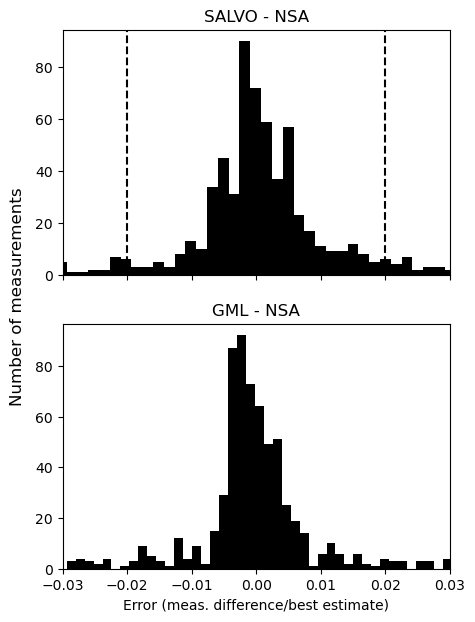

In [98]:
# Create figure comparing normalized incident distributions
df_comp['mean_incident_W_m2'] = df_comp.salvo_arm_incident + df_comp.incident_bestestimate_W_m2 + df_comp.nsa_incident

f, axs = plt.subplots(2, 1, sharex=True, figsize=(5, 7))

axs[0].hist(df_comp['diff_nsa']/df_comp['mean_incident_W_m2'], bins=200, color='k')
axs[0].axvline(x=0.02, c='k', linestyle='--')
axs[0].axvline(x=-0.02, c='k', linestyle='--')
axs[0].set_title('SALVO - NSA')

axs[1].hist(df_comp['diff_gml_nsa']/df_comp['mean_incident_W_m2'], bins=200, color='k')
axs[1].set_xlim([-0.03, 0.03])
axs[1].set_title('GML - NSA')

axs[1].set_xlabel('Error (meas. difference/best estimate)')
f.supylabel('Number of measurements')
f.savefig(os.path.join('..', 'figures', 'salvo_arm_inc_err.png'), bbox_inches='tight')

In [78]:
(df_comp['diff_nsa']/df_comp['mean_incident_W_m2']).abs().median()

0.005170335446309379

In [79]:
(df_comp['diff_gml_nsa']/df_comp['mean_incident_W_m2']).abs().median()

0.0032343972290192553

In [77]:
np.sqrt(((df_comp['diff_nsa']/df_comp['mean_incident_W_m2']).abs().median()*1.4826)**2 
        - ((df_comp['diff_gml_nsa']/df_comp['mean_incident_W_m2']).abs().median()*1.4826)**2)/1.4826

0.00403373811647159

In [76]:
0.0045**2 / 0.0072**2


0.39062499999999994

In [19]:
df_temp = line_date_agg(df, 'incident_bestestimate_W_m2')

In [20]:
df_temp.xs('arm', level='site').groupby('date_akdt').agg(['mean', 'std', 'count'])

incident_solar_W_m2                    \
                                   mean         std count   
date_akdt                                                   
2024-04-19 14:24:00          359.330488   17.348832    41   
2024-05-24 14:24:00          469.335238   11.634987    21   
2024-05-25 14:24:00          712.937805  140.514810    41   
2024-05-27 14:24:00          515.688780   18.879725    41   
2024-05-29 14:24:00          686.096341    6.061868    41   
2024-06-03 14:24:00          437.612976   73.087934    42   
2024-06-05 14:24:00          543.276910   53.695427    42   
2024-06-06 14:24:00          524.532927   31.399296    41   
2024-06-10 14:24:00          706.980488    2.200072    41   
2024-06-12 14:24:00          713.598537    3.695040    41   
2024-06-15 14:24:00          687.774286   30.019103    42   
2024-06-17 14:24:00          305.142195   16.926380    41   

                                          meantime_akdt               
                                                   mean    std count  
date_akdt                                                             
2024-04-19 14:24:00 2024-04-19 13:27:57.073170688-08:00 0 days    41  
2024-05-24 14:24:00 2024-05-24 15:58:05.714285824-08:00 0 days    21  
2024-05-25 14:24:00 2024-05-25 14:57:23.414634240-08:00 0 days    41  
2024-05-27 14:24:00 2024-05-27 12:32:21.951219456-08:00 0 days    41  
2024-05-29 14:24:00 2024-05-29 15:30:24.878048768-08:00 0 days    41  
2024-06-03 14:24:00 2024-06-03 13:47:57.209302528-08:00 0 days    42  
2024-06-05 14:24:00 2024-06-05 17:58:36.774193664-08:00 0 days    42  
2024-06-06 14:24:00 2024-06-06 14:40:39.512195072-08:00 0 days    41  
2024-06-10 14:24:00 2024-06-10 15:15:26.341463552-08:00 0 days    41  
2024-06-12 14:24:00 2024-06-12 13:27:13.170731776-08:00 0 days    41  
2024-06-15 14:24:00 2024-06-15 14:28:55.714285568-08:00 0 days    42  
2024-06-17 14:24:00 2024-06-17 13:12:20.487804672-08:00 0 days    41

In [105]:
start_date = pd.Timestamp('2024-06-12T00:00:00+00:00')
end_date = pd.Timestamp('2024-06-14T00:00:00+00:00')

df.xs((slice(start_date, end_date), 'arm', 'incident_bestestimate_W_m2'), level=('timestamp_akdt', 'site', 'variable'),
     drop_level=False)

value
timestamp_akdt            site location position repetition wavelength variable                   
2024-06-12 13:16:00-08:00 arm  line     200.0    1.0        NaN        incident_solar_W_m2  705.43
2024-06-12 13:17:00-08:00 arm  line     195.0    1.0        NaN        incident_solar_W_m2  706.09
2024-06-12 13:18:00-08:00 arm  line     190.0    1.0        NaN        incident_solar_W_m2  707.09
                                        185.0    1.0        NaN        incident_solar_W_m2  707.43
2024-06-12 13:19:00-08:00 arm  line     180.0    1.0        NaN        incident_solar_W_m2  708.09
                                        175.0    1.0        NaN        incident_solar_W_m2  709.09
2024-06-12 13:20:00-08:00 arm  line     170.0    1.0        NaN        incident_solar_W_m2  709.42
                                        165.0    1.0        NaN        incident_solar_W_m2  709.09
2024-06-12 13:21:00-08:00 arm  line     160.0    1.0        NaN        incident_solar_W_m2  709.76
                                        155.0    1.0        NaN        incident_solar_W_m2  710.09
2024-06-12 13:22:00-08:00 arm  line     150.0    1.0        NaN        incident_solar_W_m2  710.42
                                        145.0    1.0        NaN        incident_solar_W_m2  711.75
2024-06-12 13:23:00-08:00 arm  line     140.0    1.0        NaN        incident_solar_W_m2  711.75
                                        135.0    1.0        NaN        incident_solar_W_m2  713.08
2024-06-12 13:24:00-08:00 arm  line     130.0    1.0        NaN        incident_solar_W_m2  712.42
                                        125.0    1.0        NaN        incident_solar_W_m2  713.08
2024-06-12 13:25:00-08:00 arm  line     120.0    1.0        NaN        incident_solar_W_m2  714.41
                                        115.0    1.0        NaN        incident_solar_W_m2  713.75
2024-06-12 13:26:00-08:00 arm  line     110.0    1.0        NaN        incident_solar_W_m2  714.41
                                        105.0    1.0        NaN        incident_solar_W_m2  714.41
2024-06-12 13:27:00-08:00 arm  line     100.0    1.0        NaN        incident_solar_W_m2  714.41
                                        95.0     1.0        NaN        incident_solar_W_m2  714.43
2024-06-12 13:28:00-08:00 arm  line     90.0     1.0        NaN        incident_solar_W_m2  715.10
2024-06-12 13:29:00-08:00 arm  line     85.0     1.0        NaN        incident_solar_W_m2  715.10
                                        80.0     1.0        NaN        incident_solar_W_m2  715.77
2024-06-12 13:30:00-08:00 arm  line     75.0     1.0        NaN        incident_solar_W_m2  715.77
2024-06-12 13:31:00-08:00 arm  line     70.0     1.0        NaN        incident_solar_W_m2  716.45
                                        65.0     1.0        NaN        incident_solar_W_m2  716.45
2024-06-12 13:32:00-08:00 arm  line     60.0     1.0        NaN        incident_solar_W_m2  717.12
                                        55.0     1.0        NaN        incident_solar_W_m2  716.45
2024-06-12 13:33:00-08:00 arm  line     50.0     1.0        NaN        incident_solar_W_m2  716.46
2024-06-12 13:34:00-08:00 arm  line     45.0     1.0        NaN        incident_solar_W_m2  716.46
                                        40.0     1.0        NaN        incident_solar_W_m2  716.46
2024-06-12 13:35:00-08:00 arm  line     35.0     1.0        NaN        incident_solar_W_m2  717.13
                                        30.0     1.0        NaN        incident_solar_W_m2  716.46
                                        25.0     1.0        NaN        incident_solar_W_m2  716.46
2024-06-12 13:36:00-08:00 arm  line     20.0     1.0        NaN        incident_solar_W_m2  716.47
2024-06-12 13:37:00-08:00 arm  line     15.0     1.0        NaN        incident_solar_W_m2  718.13
                                        10.0     1.0        NaN        incident_solar_W_m2  717.80
                                  

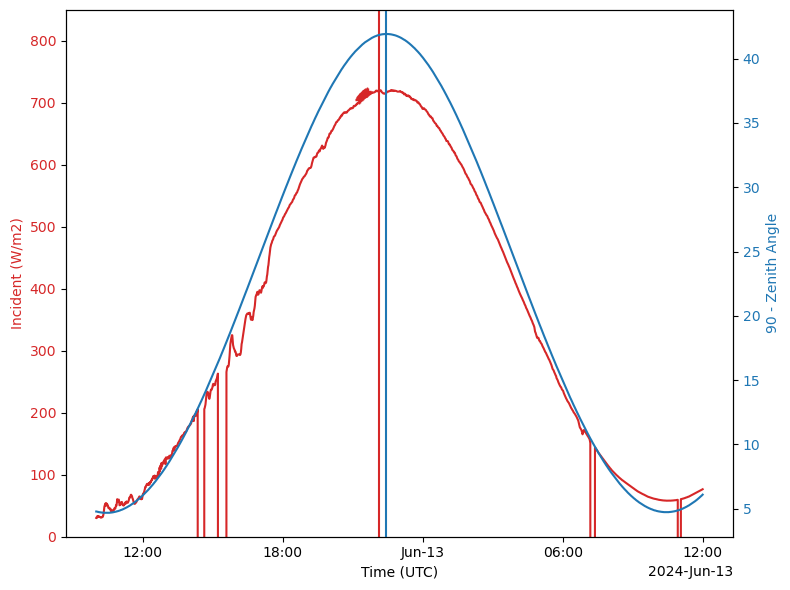

In [38]:
# Plot incident solar and zenith angle
start_date = pd.Timestamp('2024-06-12T10:00:00+00:00')
end_date = pd.Timestamp('2024-06-13T12:00:00+00:00')

df_temp = df.xs((slice(start_date, end_date), 'arm', 'incident_solar_W_m2'), level=('timestamp_akdt', 'site', 'variable'),
     drop_level=False).reset_index()

fig, ax1 = plt.subplots(figsize=(8, 6))

color = 'tab:red'
ax1.set_xlabel('Time (UTC)')
ax1.set_ylabel('Incident (W/m2)', color=color)
ax1.plot(df_gml.loc[start_date:end_date]['incident_bestestimate_W_m2'], color=color)
ax1.plot(df_temp['timestamp_akdt'], df_temp['value'], color=color, marker='+', linestyle=None)
ax1.axvline(x=df_gml.loc[start_date:end_date]['incident_bestestimate_W_m2'].idxmax(), color=color)
ax1.tick_params(axis='y', labelcolor=color)
ax1.set_ylim([0, 850])

ax2 = ax1.twinx()  # instantiate a second Axes that shares the same x-axis

color = 'tab:blue'
ax2.set_ylabel('90 - Zenith Angle', color=color)  # we already handled the x-label with ax1
ax2.plot(90 - df_gml.loc[start_date:end_date]['zen'])
ax2.axvline(x=(90 - df_gml.loc[start_date:end_date]['zen']).idxmax(), color=color)
ax2.tick_params(axis='y', labelcolor=color)

fig.tight_layout()  # otherwise the right y-label is slightly clipped

locator = mdates.AutoDateLocator(minticks=3, maxticks=7)
formatter = mdates.ConciseDateFormatter(locator)
ax1.xaxis.set_major_locator(locator)
ax1.xaxis.set_major_formatter(formatter)
plt.show()

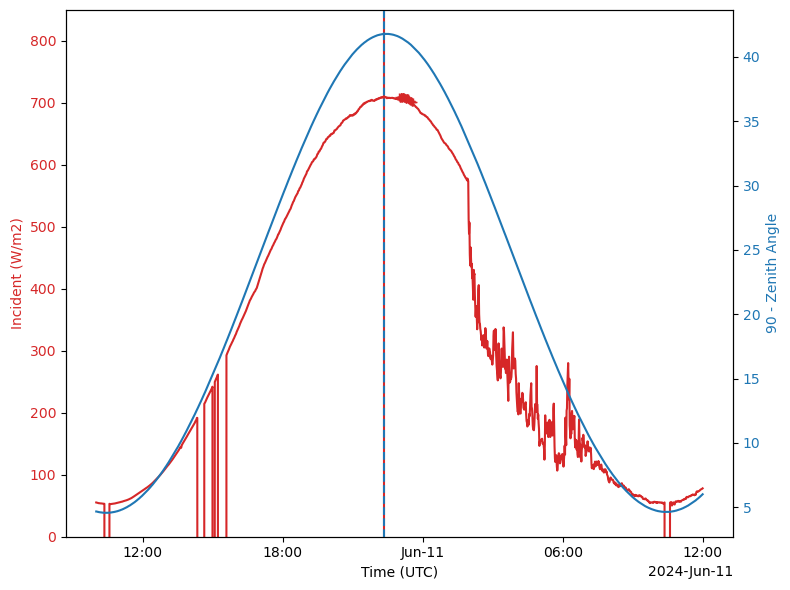

In [39]:
# Plot incident solar and zenith angle
start_date = pd.Timestamp('2024-06-10T10:00:00+00:00')
end_date = pd.Timestamp('2024-06-11T12:00:00+00:00')

df_temp = df.xs((slice(start_date, end_date), 'arm', 'incident_solar_W_m2'), level=('timestamp_akdt', 'site', 'variable'),
     drop_level=False).reset_index()

fig, ax1 = plt.subplots(figsize=(8, 6))

color = 'tab:red'
ax1.set_xlabel('Time (UTC)')
ax1.set_ylabel('Incident (W/m2)', color=color)
ax1.plot(df_gml.loc[start_date:end_date]['incident_bestestimate_W_m2'], color=color)
ax1.plot(df_temp['timestamp_akdt'], df_temp['value'], color=color, marker='+', linestyle=None)
ax1.axvline(x=df_gml.loc[start_date:end_date]['incident_bestestimate_W_m2'].idxmax(), color=color)
ax1.tick_params(axis='y', labelcolor=color)
ax1.set_ylim([0, 850])

ax2 = ax1.twinx()  # instantiate a second Axes that shares the same x-axis

color = 'tab:blue'
ax2.set_ylabel('90 - Zenith Angle', color=color)  # we already handled the x-label with ax1
ax2.plot(90 - df_gml.loc[start_date:end_date]['zen'])
ax2.axvline(x=(90 - df_gml.loc[start_date:end_date]['zen']).idxmax(), color=color, linestyle='--')
ax2.tick_params(axis='y', labelcolor=color)

fig.tight_layout()  # otherwise the right y-label is slightly clipped

locator = mdates.AutoDateLocator(minticks=3, maxticks=7)
formatter = mdates.ConciseDateFormatter(locator)
ax1.xaxis.set_major_locator(locator)
ax1.xaxis.set_major_formatter(formatter)
plt.show()

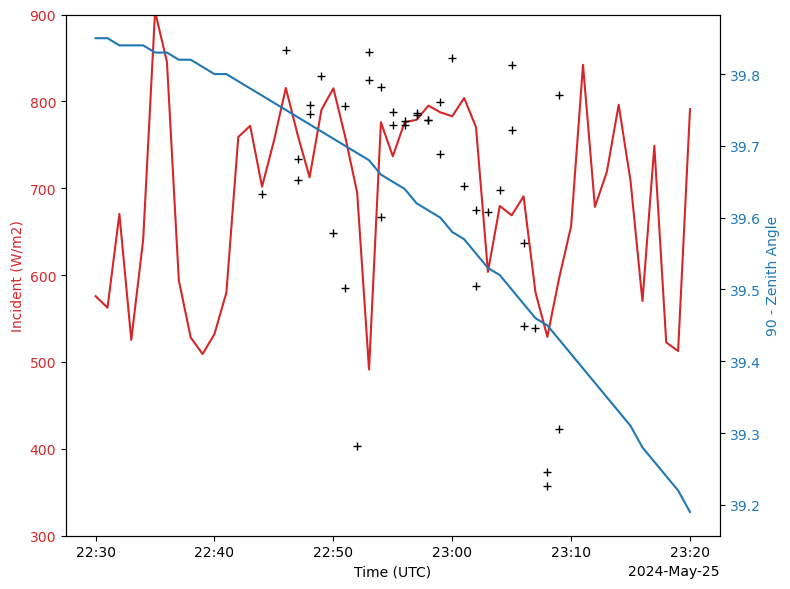

In [40]:
# Plot incident solar and zenith angle
start_date = pd.Timestamp('2024-05-25T22:30:00+00:00')
end_date = pd.Timestamp('2024-05-25T23:20:00+00:00')

df_temp = df.xs((slice(start_date, end_date), 'arm', 'incident_solar_W_m2'), level=('timestamp_akdt', 'site', 'variable'),
     drop_level=False).reset_index()

fig, ax1 = plt.subplots(figsize=(8, 6))

color = 'tab:red'
ax1.set_xlabel('Time (UTC)')
ax1.set_ylabel('Incident (W/m2)', color=color)
ax1.plot(df_gml.loc[start_date:end_date]['incident_bestestimate_W_m2'], color=color)
ax1.plot(df_temp['timestamp_akdt'], df_temp['value'], color='k', marker='+', linestyle='')
ax1.tick_params(axis='y', labelcolor=color)
ax1.set_ylim([300, 900])

ax2 = ax1.twinx()  # instantiate a second Axes that shares the same x-axis

color = 'tab:blue'
ax2.set_ylabel('90 - Zenith Angle', color=color)  # we already handled the x-label with ax1
ax2.plot(90 - df_gml.loc[start_date:end_date]['zen'])
ax2.tick_params(axis='y', labelcolor=color)

fig.tight_layout()  # otherwise the right y-label is slightly clipped

locator = mdates.AutoDateLocator(minticks=3, maxticks=7)
formatter = mdates.ConciseDateFormatter(locator)
ax1.xaxis.set_major_locator(locator)
ax1.xaxis.set_major_formatter(formatter)
plt.show()

In [23]:
# Investigate melt rates.

df_temp = line_date_agg(df, 'snow_depth_m')
df_temp.groupby(['site','date_akdt']).mean()

In [27]:
df_temp

snow_depth_m  \
site date_akdt           position                 
arm  2024-04-19 14:24:00 0.0              0.477   
                         1.0              0.419   
                         2.0              0.544   
                         3.0              0.573   
                         4.0              0.572   
...                                         ...   
ice  2024-06-18 14:24:00 196.0            0.137   
                         197.0            0.132   
                         198.0            0.096   
                         199.0            0.199   
                         200.0            0.203   

                                                        meantime_akdt  
site date_akdt           position                                      
arm  2024-04-19 14:24:00 0.0      2024-04-19 11:10:25.287014912-08:00  
                         1.0      2024-04-19 11:10:25.287014912-08:00  
                         2.0      2024-04-19 11:10:25.287014912-08:00  
                         3.0      2024-04-19 11:10:25.287014912-08:00  
                         4.0      2024-04-19 11:10:25.287014912-08:00  
...                                                               ...  
ice  2024-06-18 14:24:00 196.0    2024-06-18 13:32:30.502139392-08:00  
                         197.0    2024-06-18 13:32:30.502139392-08:00  
                         198.0    2024-06-18 13:32:30.502139392-08:00  
                         199.0    2024-06-18 13:32:30.502139392-08:00  
                         200.0    2024-06-18 13:32:30.502139392-08:00  

[7838 rows x 2 columns]

In [ ]:
# two ways of looking at mean melt rates, could look a diff of mean snow depth over time. Note that when patches are melted out
# they will have zero melt rates, and these will get averaged in causing the melt rate to tail off.
# alternatively, could just look at melt rates where we actually have snow.

# figure out how to create 'time difference' dataframe

# also look in icepack at what happens when we have patchy snow cover, what happens to melt energy